**This part of the project includes:**

1. Fitting an initial regression model, conducting statistical analyses of the results, taking a look at the p-values of the various features and perform some feature selection. 
2. Testing for regression assumptions including normality, heteroscedasticity, and independence. 
3. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.
4. Improving and deepening our answers to business problems using built models.

**MODEL FITTING & VALIDATION**
**a.	Model Building Summary Steps:**

i.	Perform Stepwise Selection to select for features with p-value < 0.05

ii.	Build the model using statsmodels with the result from stepwise selection and get r2, adjusted r2

1. Predict yhat
2.	Plot yhat regplot
3. Get intercept
4. Get coefficients

iv.	Test initial model

1.	Recheck multicollinearity with heatmap
2.	Recheck residuals normality with qqplot
3.	Recheck residuals homoscedasticity with regplot
4.	K-fold cross-validation

v.	Validate initial model

1.	Train test split and fit the line
2.	Calculate RMSE: very small difference = not overfitted
3.	Plot model residuals vs prediction with regplot
4.	Calculate accuracy percentage
5.	Bias-variance tradeoff

**b.	Models:**

i.	Model A: All features + location

ii.	Model B: All features with outliers (3 STD away) removed + location

iii.Model C: Polynomial Regression on Model A

iv.	Model D: Log transformed all continuous features (not including target ‘price) + all features 

In [2424]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle

import warnings
warnings.filterwarnings("ignore")

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

In [2425]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

price  price_log  sqft_above  sqft_above_log  sqft_lot  \
15937  268950.0  12.502281         880        6.779922      8100   
20963  399900.0  12.898970         900        6.802395      1005   
7614   339000.0  12.733755         720        6.579251      4128   
3257   380000.0  12.847927         840        6.733402      7372   
16723  365000.0  12.807653        1600        7.377759      4168   

       sqft_lot_log  sqft_living15  sqft_living15_log  sqft_lot15  age  ...  \
15937      8.999619           1000           6.907755        8100   72  ...   
20963      6.912743           1440           7.272398        1188    4  ...   
7614       8.325548           1510           7.319865        4538   73  ...   
3257       8.905444           1930           7.565275        5150   76  ...   
16723      8.335192           1190           7.081709        4168   88  ...   

       cond_5.0  zip_A  zip_B  zip_C  zip_D  zip_E  zip_F  zip_G  zip_H  zip_I  
15937         0      0      0      0      0      1      0      0      0      0  
20963         0      0      0      0      0      0      0      1      0      0  
7614          0      1      0      0      0      0      0      0      0      0  
3257          1      1      0      0      0      0      0      0      0      0  
16723         0      1      0      0      0      0      0      0      0      0  

[5 rows x 29 columns]

In [2426]:
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0',
       'reno_1.0', 'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0', 'zip_A',
       'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

### Prepare Continuous Data: Feature Scaling

In [2427]:
clean_continuous = clean[['price', 'price_log', 
                          'sqft_above', 'sqft_above_log', 
                          'sqft_lot', 'sqft_lot_log', 
                          'sqft_living15', 'sqft_living15_log', 
                          'sqft_lot15', 
                          'age']]

In [2428]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

clean_continuous_norm = clean_continuous.apply(normalize)

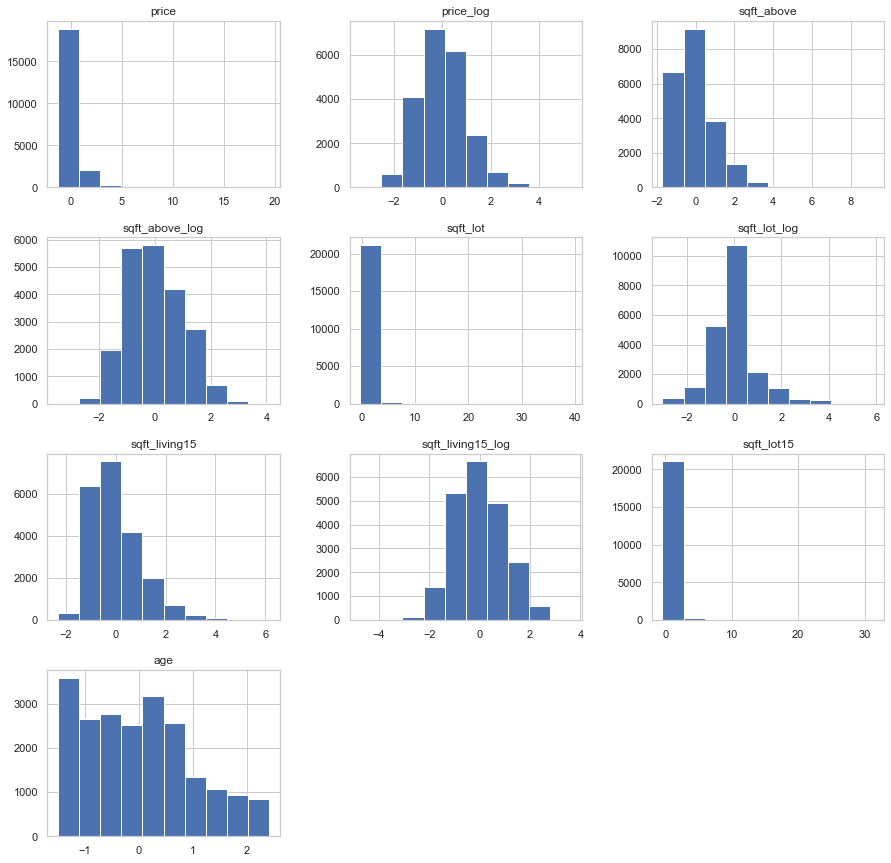

In [2429]:
#plot the new normalized data
clean_continuous_norm.hist(figsize = (15, 15));

#save
plt.savefig('./Data & Figures/log_norm_histplot')

In [2430]:
#drop old values
clean.drop(['price', 'price_log',
            'sqft_above', 'sqft_above_log',
            'sqft_lot', 'sqft_lot_log',
            'sqft_living15', 'sqft_living15_log',
            'sqft_lot15', 'age'], axis = 1, inplace = True)

In [2431]:
#add the newly standardized values
clean = pd.concat([clean, clean_continuous_norm], axis = 1) 

In [2432]:
#review
clean.head()

bedrooms  bathrooms  floors  water_1.0  base_1.0  reno_1.0  cond_2.0  \
15937         3       1.00     1.0          0         1         0         0   
20963         2       1.75     1.5          0         1         0         0   
7614          3       1.00     1.0          0         1         0         0   
3257          2       1.00     1.0          0         1         0         0   
16723         5       2.00     1.5          0         0         0         0   

       cond_3.0  cond_4.0  cond_5.0  ...     price  price_log  sqft_above  \
15937         1         0         0  ... -0.740571  -1.044412   -1.099527   
20963         1         0         0  ... -0.384457  -0.288860   -1.075393   
7614          0         1         0  ... -0.550073  -0.603535   -1.292602   
3257          0         0         1  ... -0.438575  -0.386080   -1.147796   
16723         1         0         0  ... -0.479367  -0.462787   -0.230689   

       sqft_above_log  sqft_lot  sqft_lot_log  sqft_living15  \
15937       -1.443346 -0.169225      0.011001      -1.441766   
20963       -1.390746 -0.340062     -2.297864      -0.799934   
7614        -1.913036 -0.264865     -0.734773      -0.697824   
3257        -1.552231 -0.186754     -0.093192      -0.085165   
16723       -0.044048 -0.263901     -0.724104      -1.164611   

       sqft_living15_log  sqft_lot15       age  
15937          -1.932101   -0.170986  0.955962  
20963          -0.818484   -0.423750 -1.357975  
7614           -0.673521   -0.301244  0.989991  
3257            0.075960   -0.278864  1.092076  
16723          -1.400849   -0.314775  1.500418  

[5 rows x 29 columns]

# MODEL A: 
## USING STEPWISE SELECTION
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

In [2433]:
clean.columns

Index(['bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0', 'zip_A', 'zip_B',
       'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'price',
       'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot', 'sqft_lot_log',
       'sqft_living15', 'sqft_living15_log', 'sqft_lot15', 'age'],
      dtype='object')

In [2434]:
#including all non-log-transformed features
preprocessed_A = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 
                      'water_1.0', 'base_1.0', 'reno_1.0',
                      'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0',
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [2435]:
#review
preprocessed_A.head(2)

price  sqft_above  sqft_lot  sqft_living15  sqft_lot15       age  \
15937 -0.740571   -1.099527 -0.169225      -1.441766   -0.170986  0.955962   
20963 -0.384457   -1.075393 -0.340062      -0.799934   -0.423750 -1.357975   

       bedrooms  bathrooms  floors  water_1.0  ...  cond_5.0  zip_A  zip_B  \
15937         3       1.00     1.0          0  ...         0      0      0   
20963         2       1.75     1.5          0  ...         0      0      0   

       zip_C  zip_D  zip_E  zip_F  zip_G  zip_H  zip_I  
15937      0      0      1      0      0      0      0  
20963      0      0      0      0      1      0      0  

[2 rows x 25 columns]

In [2436]:
preprocessed_A.shape

(21420, 25)

In [2437]:
preprocessed_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 15937 to 2495
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21420 non-null  float64
 1   sqft_above     21420 non-null  float64
 2   sqft_lot       21420 non-null  float64
 3   sqft_living15  21420 non-null  float64
 4   sqft_lot15     21420 non-null  float64
 5   age            21420 non-null  float64
 6   bedrooms       21420 non-null  int64  
 7   bathrooms      21420 non-null  float64
 8   floors         21420 non-null  float64
 9   water_1.0      21420 non-null  int64  
 10  base_1.0       21420 non-null  int64  
 11  reno_1.0       21420 non-null  int64  
 12  cond_2.0       21420 non-null  int64  
 13  cond_3.0       21420 non-null  int64  
 14  cond_4.0       21420 non-null  int64  
 15  cond_5.0       21420 non-null  int64  
 16  zip_A          21420 non-null  int64  
 17  zip_B          21420 non-null  int64  
 18  zip

In [2438]:
#define X, y training set
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

### Perform Stepwise Selection

In [2439]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list = [], 
                       threshold_in = 0.01, 
                       threshold_out = 0.05, 
                       verbose = True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.remove(worst_feature_name)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

In [2440]:
#apply function
result_A = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_A)

Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  sqft_living15                  with p-value 9.57815e-223
Add  zip_B                          with p-value 2.20164e-177
Add  age                            with p-value 5.45065e-142
Add  zip_G                          with p-value 5.05849e-93
Add  bathrooms                      with p-value 2.81949e-88
Add  bedrooms                       with p-value 1.57939e-89
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
A

Recall that a common significance cutoff of p-value is 0.05. Our model should eliminate these irrelevant features.

The null hypothesis H0 for multiple regression states that there is no relationship between the chosen features and the target 'price'. All of the above p-values round to 0, which means we can reject H0. All of the p-values indicate that all of the current features are substantially influential.

In [2441]:
#check out how many features satisfy p < 0.05
len(result_A)

19

## Build Model A

In [2442]:
#build Model A in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_A]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2269.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:26:38   Log-Likelihood:                -18575.
No. Observations:               21420   AIC:                         3.719e+04
Df Residuals:                   21400   BIC:                         3.735e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7156      0.049    -14.539      0.000      -0.812      -0.619
sqft_above        0.5371      0.008     66.059      0.000       0.521       0.553
zip_A             0.7339      0.014     52.183      0.000       0.706       0.761
base_1.0          0.3287      0.011     31.006      0.000       0.308       0.350
zip_C             0.7859      0.016     49.607      0.000       0.755       0.817
water_1.0         2.3157      0.049     47.598      0.000       2.220       2.411
sqft_living15     0.1774      0.006     27.777      0.000       0.165       0.190
zip_B             0.4750      0.015     31.426      0.000       0.445       0.505
age               0.1435      0.006     23.171      0.000       0.131       0.156
zip_G             0.3449      0.017     19.799      0.000       0.311       0.379
bathrooms         0.2142      0.009     23.153      0.000       0.196       0.232
bedrooms         -0.1109      0.006    -20.016      0.000      -0.122      -0.100
zip_F            -0.0820      0.018     -4.681      0.000      -0.116      -0.048
cond_3.0          0.0881      0.043      2.072      0.038       0.005       0.171
reno_1.0          0.1796      0.023      7.858      0.000       0.135       0.224
zip_E             0.1397      0.019      7.297      0.000       0.102       0.177
zip_I             0.1628      0.026      6.293      0.000       0.112       0.214
cond_5.0          0.2497      0.044      5.632      0.000       0.163       0.337
floors           -0.0567      0.011     -5.370      0.000      -0.077      -0.036
cond_4.0          0.1677      0.043      3.931      0.000       0.084       0.251
==============================================================================
Omnibus:                    17979.101   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1611084.563
Skew:                           3.531   Prob(JB):                         0.00
Kurtosis:                      44.896   Cond. No.                         99.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* p-value of 0 which rejects the null hypothesis.
* Additionally, the kurtosis is > 3, indicating heavier tails than a normal distribution. 
* The skewness value of 3.5 shows that underlying data is not symmetrical. 

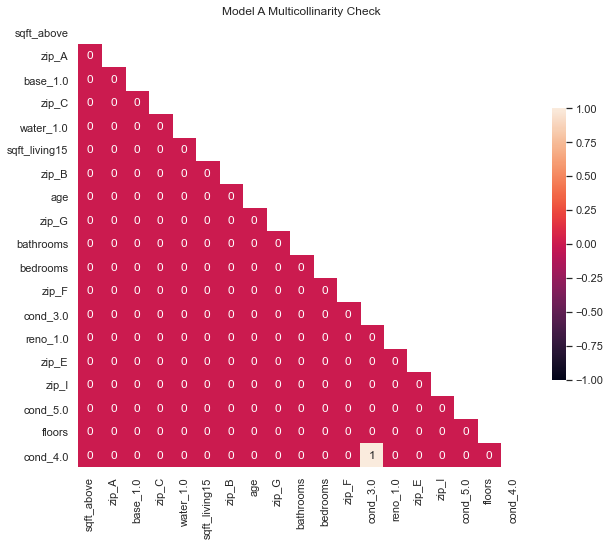

In [2443]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_A].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_A].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model A Multicollinarity Check')
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

In [2444]:
#drop 'cond_4.0' to avoid multicollinearity
preprocessed_A.drop('cond_4.0', axis = 1, inplace = True)

In [2445]:
#redefine X, y training set
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

In [2446]:
#redo stepwise selection
result_A = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_A)

Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  sqft_living15                  with p-value 9.57815e-223
Add  zip_B                          with p-value 2.20164e-177
Add  age                            with p-value 5.45065e-142
Add  zip_G                          with p-value 5.05849e-93
Add  bathrooms                      with p-value 2.81949e-88
Add  bedrooms                       with p-value 1.57939e-89
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
A

In [2447]:
#rebuild Model A
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_A]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2268.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:26:42   Log-Likelihood:                -18578.
No. Observations:               21420   AIC:                         3.720e+04
Df Residuals:                   21400   BIC:                         3.736e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5501      0.028    -19.884      0.000      -0.604      -0.496
sqft_above        0.5373      0.008     66.073      0.000       0.521       0.553
zip_A             0.7337      0.014     52.164      0.000       0.706       0.761
base_1.0          0.3292      0.011     31.052      0.000       0.308       0.350
zip_C             0.7859      0.016     49.600      0.000       0.755       0.817
water_1.0         2.3150      0.049     47.575      0.000       2.220       2.410
sqft_living15     0.1772      0.006     27.739      0.000       0.165       0.190
zip_B             0.4748      0.015     31.407      0.000       0.445       0.504
age               0.1431      0.006     23.120      0.000       0.131       0.155
zip_G             0.3447      0.017     19.784      0.000       0.311       0.379
bathrooms         0.2142      0.009     23.157      0.000       0.196       0.232
bedrooms         -0.1107      0.006    -19.977      0.000      -0.122      -0.100
zip_F            -0.0821      0.018     -4.685      0.000      -0.116      -0.048
cond_3.0         -0.0780      0.010     -7.753      0.000      -0.098      -0.058
reno_1.0          0.1798      0.023      7.865      0.000       0.135       0.225
zip_E             0.1390      0.019      7.259      0.000       0.101       0.176
zip_I             0.1622      0.026      6.268      0.000       0.111       0.213
cond_5.0          0.0838      0.016      5.160      0.000       0.052       0.116
floors           -0.0569      0.011     -5.387      0.000      -0.078      -0.036
cond_2.0         -0.1352      0.046     -2.937      0.003      -0.225      -0.045
==============================================================================
Omnibus:                    17964.927   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1607735.037
Skew:                           3.527   Prob(JB):                         0.00
Kurtosis:                      44.853   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2448]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_A], y)

#predict yhat using our model
yhat = linreg.predict(X[result_A])
yhat

array([-1.04396899, -0.79988517, -0.33824057, ..., -0.71789283,
       -0.34289998, -0.52898149])

In [2449]:
#get intercept
linreg.intercept_

-0.550135539414707

In [2450]:
#get coefficients and sort them
coefficients_A = dict(zip(X[result_A], list(linreg.coef_)))
dict(sorted(coefficients_A.items(), key = lambda item: item[1]))

{'cond_2.0': -0.1352321102557106,
 'bedrooms': -0.11066913362648338,
 'zip_F': -0.08210151123050999,
 'cond_3.0': -0.07800378763802411,
 'floors': -0.0568537978085889,
 'cond_5.0': 0.08376544156920178,
 'zip_E': 0.13896434716421496,
 'age': 0.14314370392407572,
 'zip_I': 0.16220670743991628,
 'sqft_living15': 0.17720665726244708,
 'reno_1.0': 0.179828883176655,
 'bathrooms': 0.21423240143100866,
 'base_1.0': 0.3292482733084535,
 'zip_G': 0.3446530600607669,
 'zip_B': 0.4748351089055151,
 'sqft_above': 0.5372882770934375,
 'zip_A': 0.7337234937057014,
 'zip_C': 0.7858900555592199,
 'water_1.0': 2.314977026777244}

In [2451]:
!pip install waterfallcharts
!pip install plotly==4.14.3
import waterfall_chart
import plotly.graph_objects as go

In [2452]:
lists_A = sorted(coefficients_A.items(), key = lambda item: item[1])
a, b = zip(*lists_A)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model A Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_A_waterfall.png')

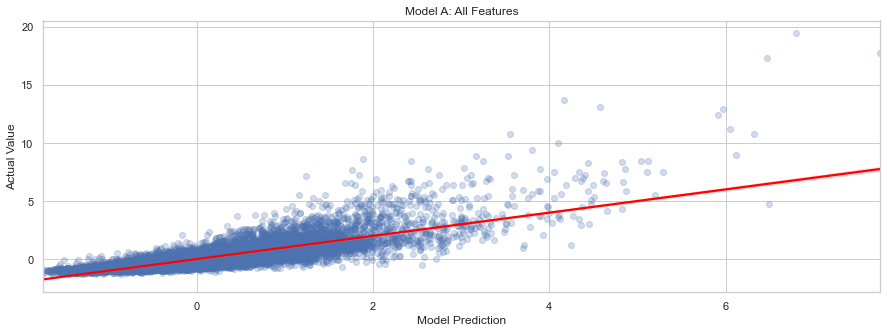

In [2453]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model A: All Features')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_A_regplot')

## Rank Features for Model A

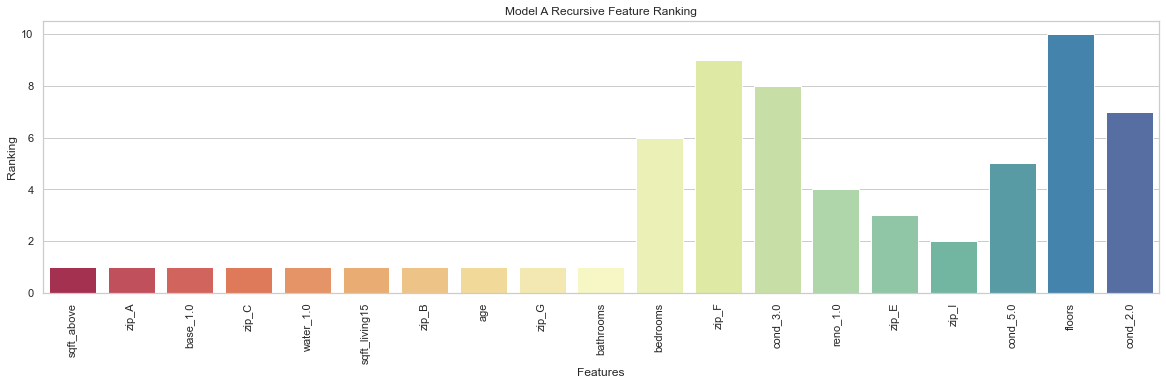

<Figure size 432x288 with 0 Axes>

In [2454]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_A], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_A].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model A Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_A_recursive_features_elimination')

## Test Model A

**Recheck for multicollinearity**

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables (features X) within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

VIF quantifies how much the variance is inflated.

In [2455]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_A].values, i) for i in range(X[result_A].shape[1])] 
list(zip(result_A, vif))

[('sqft_above', 3.148057722816477),
 ('zip_A', 4.290652617544416),
 ('base_1.0', 2.7822492090783775),
 ('zip_C', 1.824919485985968),
 ('water_1.0', 1.0400373391710502),
 ('sqft_living15', 2.6318276577199327),
 ('zip_B', 1.8220859772868632),
 ('age', 2.2423648207258178),
 ('zip_G', 1.5956441254772724),
 ('bathrooms', 24.5808924376999),
 ('bedrooms', 17.341313318594572),
 ('zip_F', 1.459053857213612),
 ('cond_3.0', 4.023563239782995),
 ('reno_1.0', 1.1559974679711245),
 ('zip_E', 1.447622818171428),
 ('zip_I', 1.179919990138253),
 ('cond_5.0', 1.3350267944167478),
 ('floors', 14.997470031513634),
 ('cond_2.0', 1.0299440989722572)]

While the p-values indicate that all of the current features are impactful, the variance inflation factor indicates that there is moderate multicollinearity between our variables.  A rule of thumb commonly used in practice is if a VIF is > 10, we have high multicollinearity, and the parameter estimates will have large standard errors because of this. We see here those 'problematic' features are:

* 'cond_3.0', 23.10854748754023
* 'floors', 17.115709258109163

Let's recheck for multicollinearity.

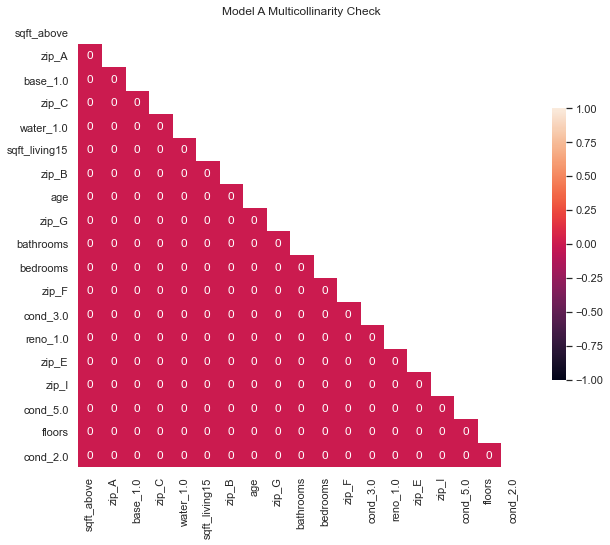

In [2456]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_A].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_A].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model A Multicollinarity Check')
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

**Recheck for normality**

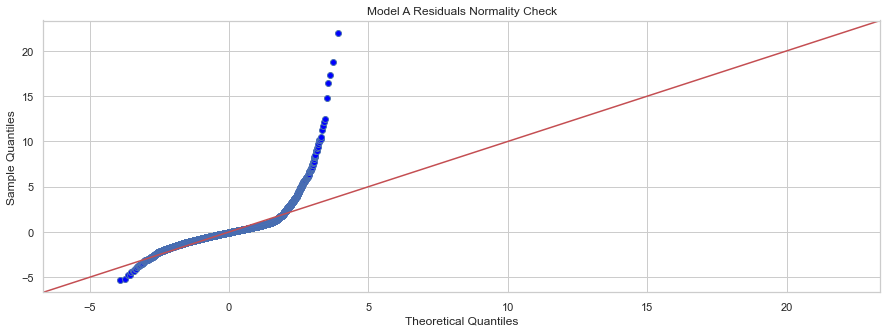

<Figure size 432x288 with 0 Axes>

In [2457]:
#recheck for normality
fig = sm.graphics.qqplot(model_A.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model A Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_A_residuals_qqplot')

**Recheck for homoscedasticity**

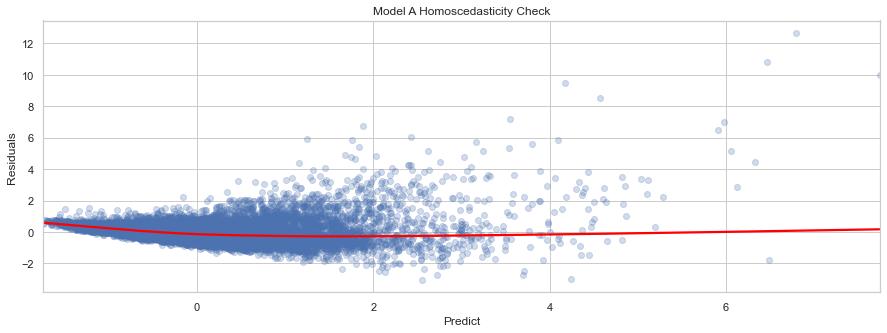

<Figure size 432x288 with 0 Axes>

In [2458]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_A.predict(), 
            y = model_A.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25})
plt.title('Model A Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_A_homoscedasticity_regplot')

In [2459]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_A.resid, model_A.model.exog)
list(zip(name, test))

[('F statistic', 1.0157928175913467), ('p-value', 0.20896254809615292)]

**Recheck for overfitting: K-Fold Cross Validation**

In [2460]:
#cross-validation to check for overfitting
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X[result_A], y, cv = 10, scoring = 'neg_root_mean_squared_error')
cv_result

array([-0.66858595, -0.46775637, -0.53893646, -0.64068209, -0.55984854,
       -0.56762791, -0.55380824, -0.58987118, -0.63282159, -0.55805453])

In [2461]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

-0.5777992863541214

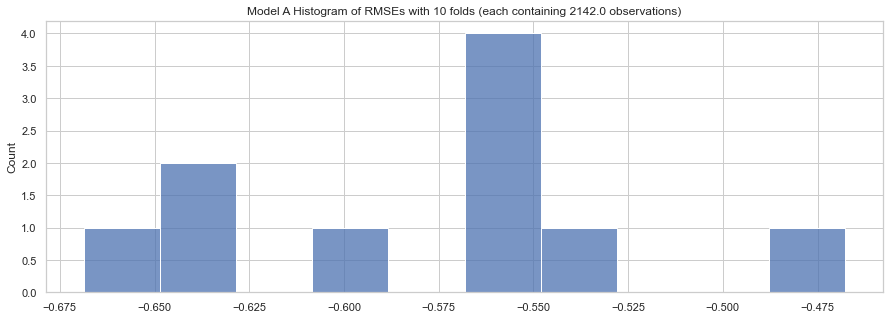

In [2462]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_A) / folds, 0)));
plt.savefig('./Data & Figures/model_A_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model A

In order to get a good sense of how well our model will be doing on new instances, we'll have to perform a so-called "train-test-split". What we'll be doing here, is take a sample of the data that serves as input to "train" our model - fit a linear regression and compute the parameter estimates for our variables, and calculate how well our predictive performance is doing comparing the actual targets y and the fitted yhat obtained by our model.

* Underfitting happens when a model cannot learn the training data, nor can it generalize to new data.
* Overfitting happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data

In [2463]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[result_A], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [2464]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [2465]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [2466]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

0.5625265909631905
0.6286713292932755


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

In [2467]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 66%'

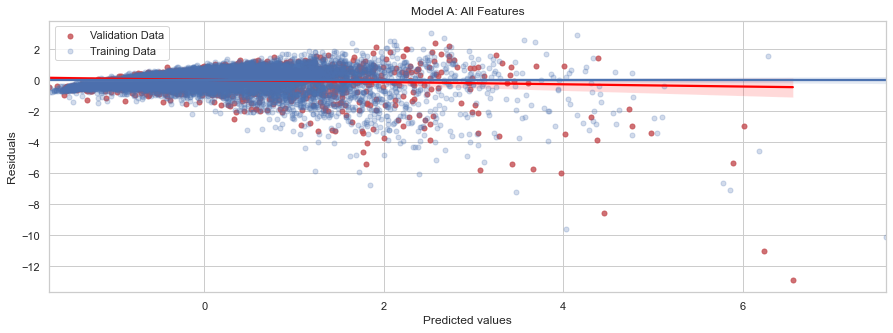

<Figure size 432x288 with 0 Axes>

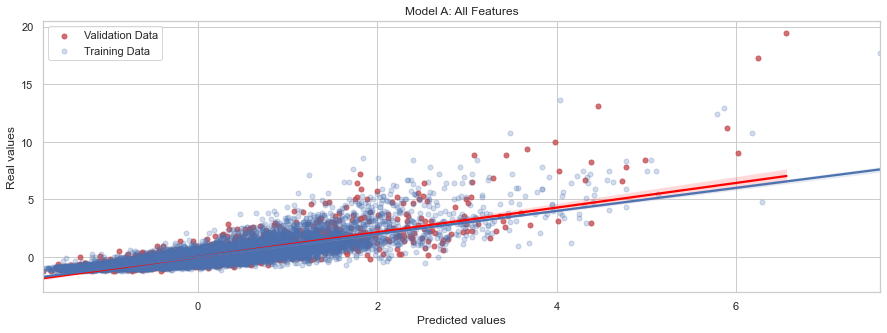

<Figure size 432x288 with 0 Axes>

In [2468]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_predictions_regplot')

**Bias-Variance Tradeoff**

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [2469]:
#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

In [2470]:
#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [2471]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [2472]:
#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

Train bias: 0.1866438695124173 
Train variance: 0.21068111996219904


In [2473]:
#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Test bias: 0.17987848096081746 
Test variance: 0.2052605814854413


In [2474]:
import pickle

#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_A.pkl','wb'))

In [2475]:
#summary table
summary_table_1 = pd.DataFrame({'Model': [], 'Description':[], ' Num Features' : [], 
                                'r2': [], 'Accuracy':[], 
                                'RMSE Train': [], 'RMSE Test': [],
                                'Bias Train': [], 'Bias Test': [], 'Variance Train': [], 'Variance Test': [],
                                'Cross Validation': [],
                                'Multicollinearity': [], 'Normality': [], 'Homoscedasticity': []})
summary_table_1.loc[0] = ['Model A', 'All features', len(result_A), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

Model   Description   Num Features        r2   Accuracy  RMSE Train  \
0  Model A  All features           19.0  0.668177  66.236718    0.562527   

   RMSE Test  Bias Train  Bias Test  Variance Train  Variance Test  \
0   0.628671    0.186644   0.179878        0.210681       0.205261   

   Cross Validation Multicollinearity Normality Homoscedasticity  
0         -0.577799                 P         F                F

# MODEL B 
## REMOVE OUTLIERS THAT ARE 3 STD AWAY FROM THE MEAN

In [2476]:
#review
preprocessed_A.columns

Index(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'age',
       'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

In [2477]:
#removie outliers in 'bedrooms'
count = 0
bedrooms_outliers = []
mean = np.mean(preprocessed_A['bedrooms'])
std = np.std(preprocessed_A['bedrooms'])
cut_off = np.std(preprocessed_A['bedrooms']) * 3 

for idx, row in preprocessed_A['bedrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

61

In [2478]:
#removie outliers in 'bathrooms'
count = 0
bathrooms_outliers = []
mean = np.mean(preprocessed_A['bathrooms'])
std = np.std(preprocessed_A['bathrooms'])
cut_off = np.std(preprocessed_A['bathrooms']) * 3 

for idx, row in preprocessed_A['bathrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

171

In [2479]:
#create new dataframe excluding outliers
preprocessed_B = preprocessed_A[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 
                                 'age', 'bedrooms', 'bathrooms', 'floors', 
                                 'water_1.0', 'base_1.0', 'reno_1.0',
                                 'cond_2.0', 'cond_3.0', 'cond_5.0', 
                                 'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [2480]:
X = preprocessed_B.drop(['price'], axis = 1)
y = preprocessed_B['price']

## RECURSIVE FEATURE RANKING

Stepwise Selection selects features based on p-value. RFE ranks the variable on the basis on linear regression fit.
By combining them, we select for the 10 most important features.

RFE is effective at selecting those features in a training dataset that are more or most relevant in predicting the target variable.

RFE assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [2481]:
#apply stepwise function
result_B = stepwise_selection(X, y, verbose=True)
print('Resulting Features:')
print(result_B)

Add  sqft_above                     with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  zip_B                          with p-value 3.15565e-164
Add  age                            with p-value 2.33997e-136
Add  zip_G                          with p-value 1.06903e-93
Add  bathrooms                      with p-value 3.65168e-73
Add  bedrooms                       with p-value 6.26971e-66
Add  cond_3.0                       with p-value 5.63341e-20
Add  reno_1.0                       with p-value 5.59952e-18
Add  zip_E                          with p-value 3.741e-12
Add  zip_I                          with p-value 6.77894e-15
Add  cond_5.0                       with p-value 6.35801e-12
Add  sqft_lot      

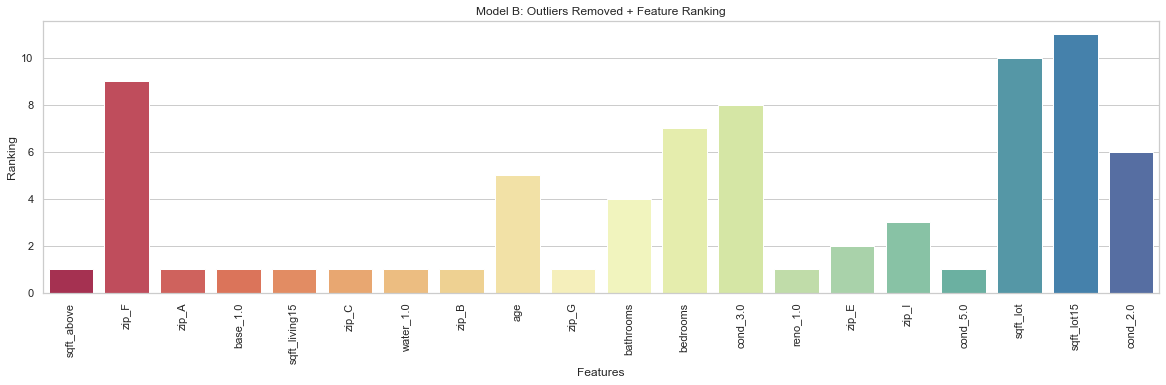

<Figure size 432x288 with 0 Axes>

In [2482]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_B], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_B].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_B_recursive_features_elimination')

In [2483]:
#fit the linear regression model again using the selected columns
selected_features = X[result_B].columns[selector.support_ ]

linreg.fit(X[selected_features], y)

LinearRegression()

In [2484]:
#get intercept
linreg.intercept_

-0.6349657945880696

In [2485]:
#get coefficients and sort them
coefficients_B = dict(zip(X[selected_features], list(linreg.coef_)))
dict(sorted(coefficients_B.items(), key = lambda item: item[1]))

{'sqft_living15': 0.21968960631806697,
 'cond_5.0': 0.22946359575498285,
 'zip_G': 0.32740052277666815,
 'reno_1.0': 0.3326967502018445,
 'base_1.0': 0.3402208686698675,
 'sqft_above': 0.4496375425627228,
 'zip_B': 0.4614148154974263,
 'zip_C': 0.7465037765474472,
 'zip_A': 0.7706373196540303,
 'water_1.0': 2.1694931096225236}

In [2486]:
lists_B = sorted(coefficients_B.items(), key = lambda item: item[1])
a, b = zip(*lists_B)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model B Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_B_waterfall.png')

## Build Model B

In [2487]:
#build model B 
#interecept is not included by default and should be added manually
X_in = X[selected_features]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_B = sm.OLS(y, X_intercept).fit() 

#get summary
model_B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     3811.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:27:09   Log-Likelihood:                -16842.
No. Observations:               21188   AIC:                         3.371e+04
Df Residuals:                   21177   BIC:                         3.379e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6350      0.007    -89.647      0.000      -0.649      -0.621
sqft_above        0.4496      0.006     72.821      0.000       0.438       0.462
zip_A             0.7706      0.009     81.403      0.000       0.752       0.789
base_1.0          0.3402      0.008     40.289      0.000       0.324       0.357
sqft_living15     0.2197      0.006     36.156      0.000       0.208       0.232
zip_C             0.7465      0.013     57.550      0.000       0.721       0.772
water_1.0         2.1695      0.047     46.069      0.000       2.077       2.262
zip_B             0.4614      0.012     37.873      0.000       0.438       0.485
zip_G             0.3274      0.015     22.401      0.000       0.299       0.356
reno_1.0          0.3327      0.021     16.229      0.000       0.293       0.373
cond_5.0          0.2295      0.014     16.593      0.000       0.202       0.257
==============================================================================
Omnibus:                    13050.428   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           311682.621
Skew:                           2.544   Prob(JB):                         0.00
Kurtosis:                      21.087   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

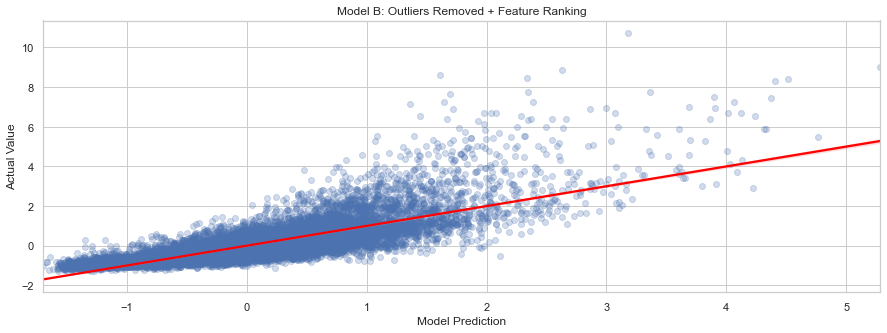

In [2488]:
#predict yhat using our model
yhat = linreg.predict(X[selected_features])
yhat

#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_B_regplot')

## Test Model B

In [2489]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[selected_features].values, i) for i in range(X[selected_features].shape[1])] 
list(zip(selected_features, vif))

[('sqft_above', 2.4906156861493103),
 ('zip_A', 1.5919288487173633),
 ('base_1.0', 1.817036828474217),
 ('sqft_living15', 2.519508089485655),
 ('zip_C', 1.1511314313714078),
 ('water_1.0', 1.0169832185601877),
 ('zip_B', 1.0945575208882412),
 ('zip_G', 1.0833801992863918),
 ('reno_1.0', 1.0483186572933074),
 ('cond_5.0', 1.105704159703799)]

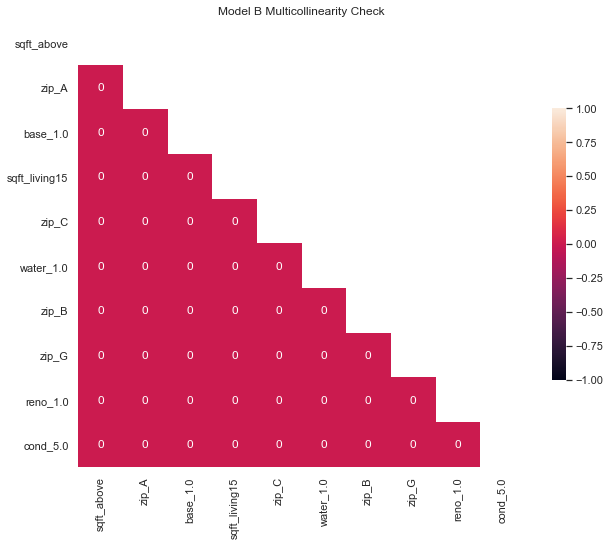

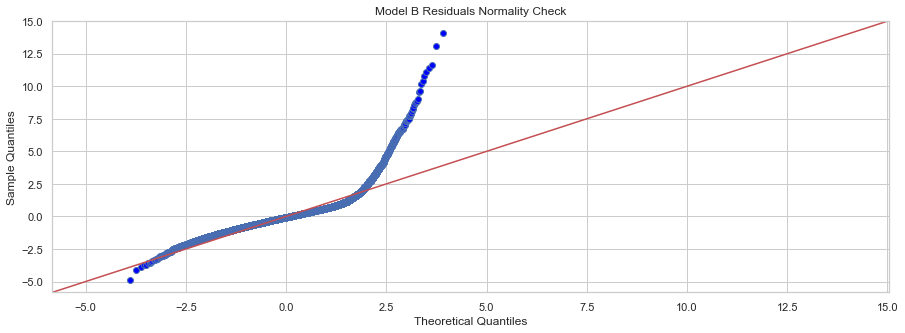

<Figure size 432x288 with 0 Axes>

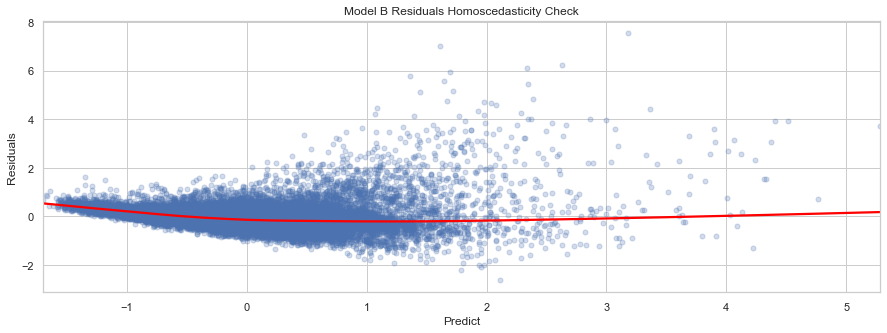

<Figure size 432x288 with 0 Axes>

In [2490]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[selected_features].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[selected_features].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model B Multicollinearity Check')
plt.savefig('./Data & Figures/model_B_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_B.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model B Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_B.predict(), 
            y = model_B.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha': 0.25})
plt.title('Model B Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_B_homoscedasticity_regplot')

In [2491]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_B.resid, model_B.model.exog)
list(zip(name, test))

[('F statistic', 1.1212312794683894), ('p-value', 2.0018047624539533e-09)]

In [2492]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[selected_features], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

-0.536612241558005


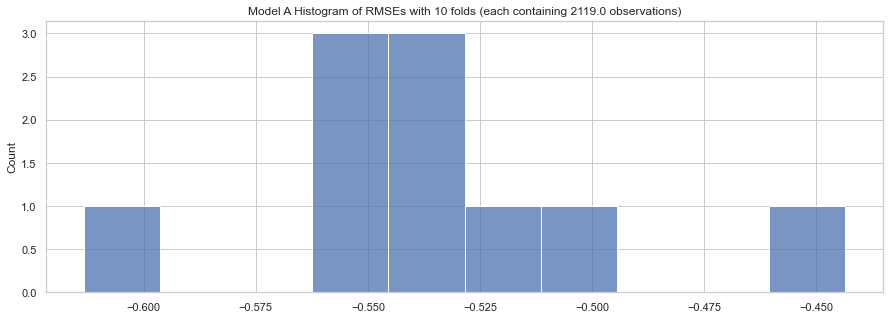

In [2493]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_B) / folds, 0)));
plt.savefig('./Data & Figures/model_B_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model B

In [2494]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test RMSE
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

16950 16950 4238 4238
0.5357511479265694
0.5360749751223352


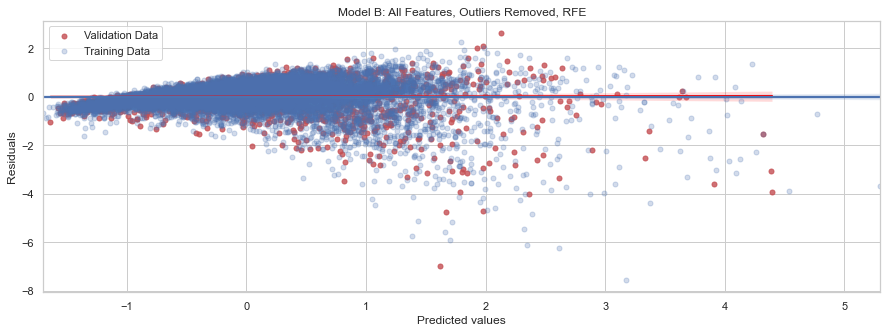

<Figure size 432x288 with 0 Axes>

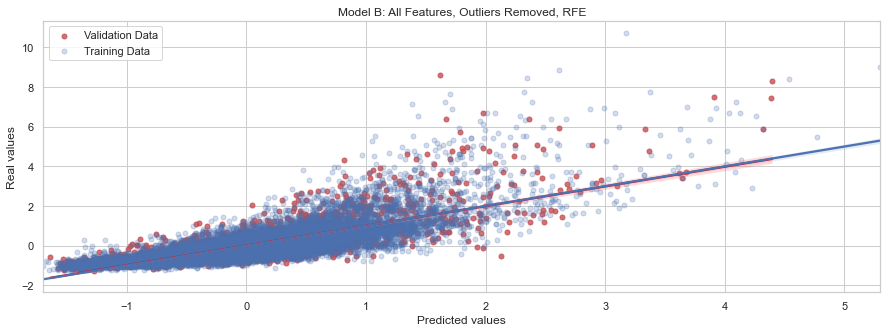

<Figure size 432x288 with 0 Axes>

In [2495]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model B: All Features, Outliers Removed, RFE')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model B: All Features, Outliers Removed, RFE')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_predictions_regplot')

In [2496]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 64%'

In [2497]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.16968353025916824 
Train variance: 0.20843375904757558
Test bias: 0.16323940425182512 
Test variance: 0.20986246274746134


In [2498]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_B.pkl','wb'))

In [2499]:
summary_table_1.loc[1] = ['Model B', 'All features, outliers removed, RFE', len(selected_features), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

Model                          Description   Num Features        r2  \
0  Model A                         All features           19.0  0.668177   
1  Model B  All features, outliers removed, RFE           10.0  0.642821   

    Accuracy  RMSE Train  RMSE Test  Bias Train  Bias Test  Variance Train  \
0  66.236718    0.562527   0.628671    0.186644   0.179878        0.210681   
1  63.983660    0.535751   0.536075    0.169684   0.163239        0.208434   

   Variance Test  Cross Validation Multicollinearity Normality  \
0       0.205261         -0.577799                 P         F   
1       0.209862         -0.536612                 P         F   

  Homoscedasticity  
0                F  
1                F

# MODEL C
## POLYNOMIAL REGRESSION

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. The troublesome features are 'price', 'sqft_above', 'sqft_lot', 'sqft_living15', and 'sqft_lot15'.

Model C will be a refinement of Model A, since Model B (with outliers removed) did not improve and we don't want to remove outliers without a convincing reason.

In [2500]:
#create new dataframe
preprocessed_C = preprocessed_A.copy(deep = True)

preprocessed_C.head(2)

price  sqft_above  sqft_lot  sqft_living15  sqft_lot15       age  \
15937 -0.740571   -1.099527 -0.169225      -1.441766   -0.170986  0.955962   
20963 -0.384457   -1.075393 -0.340062      -0.799934   -0.423750 -1.357975   

       bedrooms  bathrooms  floors  water_1.0  ...  cond_5.0  zip_A  zip_B  \
15937         3       1.00     1.0          0  ...         0      0      0   
20963         2       1.75     1.5          0  ...         0      0      0   

       zip_C  zip_D  zip_E  zip_F  zip_G  zip_H  zip_I  
15937      0      0      1      0      0      0      0  
20963      0      0      0      0      1      0      0  

[2 rows x 24 columns]

In [2501]:
#transform non-normal features
preprocessed_C['sqft_above_poly'] = preprocessed_C['sqft_above']**2
preprocessed_C['sqft_lot_poly'] = preprocessed_C['sqft_lot']**2
preprocessed_C['sqft_living15_poly'] = preprocessed_C['sqft_living15']**2
preprocessed_C['sqft_lot15_poly'] = preprocessed_C['sqft_lot15']**2

In [2502]:
#drop old values
preprocessed_C.drop(['sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15'], axis = 1, inplace = True)

In [2503]:
#review dataframe
preprocessed_C.head(2)

price       age  bedrooms  bathrooms  floors  water_1.0  base_1.0  \
15937 -0.740571  0.955962         3       1.00     1.0          0         1   
20963 -0.384457 -1.357975         2       1.75     1.5          0         1   

       reno_1.0  cond_2.0  cond_3.0  ...  zip_D  zip_E  zip_F  zip_G  zip_H  \
15937         0         0         1  ...      0      1      0      0      0   
20963         0         0         1  ...      0      0      0      1      0   

       zip_I  sqft_above_poly  sqft_lot_poly  sqft_living15_poly  \
15937      0         1.208959       0.028637            2.078689   
20963      0         1.156469       0.115642            0.639894   

       sqft_lot15_poly  
15937         0.029236  
20963         0.179564  

[2 rows x 24 columns]

In [2504]:
#redefine X_train and y_train
X = preprocessed_C.drop(['price'], axis = 1)
y = preprocessed_C['price']

In [2505]:
#apply stepwise function to make sure we only select impactful features
result_C = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_C)

Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  sqft_living15_poly             with p-value 0.0
Add  water_1.0                      with p-value 9.62953e-287
Add  zip_C                          with p-value 4.03208e-248
Add  zip_A                          with p-value 2.84141e-271
Add  sqft_above_poly                with p-value 7.2691e-273
Add  zip_B                          with p-value 1.66968e-270
Add  zip_G                          with p-value 1.01702e-186
Add  zip_I                          with p-value 7.68426e-25
Add  base_1.0                       with p-value 5.50068e-23
Add  floors                         with p-value 1.00168e-50
Add  bedrooms                       with p-value 9.69856e-18
Add  reno_1.0                       with p-value 9.83632e-13
Add  cond_3.0                       with p-value 1.74446e-14
Add  sqft_lot_poly                  with p-value 1.98258e-09
Add  zip_F                          with p-

## Build Model C

In [2506]:
#interecept is not included by default and should be added manually
X_in = X[result_C]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_C = sm.OLS(y, X_intercept).fit() 

#get summary
model_C.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     1575.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:27:30   Log-Likelihood:                -18415.
No. Observations:               21188   AIC:                         3.687e+04
Df Residuals:                   21168   BIC:                         3.703e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.9673      0.022    -87.459      0.000      -2.011      -1.923
bathrooms              0.4555      0.009     51.713      0.000       0.438       0.473
age                    0.1649      0.006     26.762      0.000       0.153       0.177
sqft_living15_poly     0.0867      0.003     30.964      0.000       0.081       0.092
water_1.0              2.2162      0.051     43.510      0.000       2.116       2.316
zip_C                  0.8121      0.016     50.030      0.000       0.780       0.844
zip_A                  0.5116      0.014     36.406      0.000       0.484       0.539
sqft_above_poly        0.1072      0.003     37.125      0.000       0.102       0.113
zip_B                  0.5510      0.015     35.582      0.000       0.521       0.581
zip_G                  0.4439      0.018     24.987      0.000       0.409       0.479
zip_I                  0.2249      0.026      8.556      0.000       0.173       0.276
base_1.0               0.1416      0.010     14.445      0.000       0.122       0.161
floors                 0.1568      0.010     15.026      0.000       0.136       0.177
bedrooms               0.0498      0.006      8.984      0.000       0.039       0.061
reno_1.0               0.1915      0.023      8.259      0.000       0.146       0.237
cond_3.0              -0.0789      0.010     -8.276      0.000      -0.098      -0.060
sqft_lot_poly          0.0014      0.000      5.940      0.000       0.001       0.002
zip_F                 -0.1171      0.018     -6.542      0.000      -0.152      -0.082
cond_2.0              -0.2415      0.046     -5.250      0.000      -0.332      -0.151
zip_D                 -0.0564      0.018     -3.123      0.002      -0.092      -0.021
==============================================================================
Omnibus:                    11098.339   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183348.891
Skew:                           2.139   Prob(JB):                         0.00
Kurtosis:                      16.762   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2507]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_C], y)

#predict yhat using our model
yhat = linreg.predict(X[result_C])
yhat

array([-0.67545315, -0.37318999, -0.16766649, ..., -1.14706158,
       -0.40839693, -0.23751394])

In [2508]:
#get intercept
linreg.intercept_

-1.9672598388643256

In [2509]:
#get coefficients and sort them
coefficients_C = dict(zip(X[result_C], list(linreg.coef_)))
dict(sorted(coefficients_C.items(), key = lambda item: item[1]))

{'cond_2.0': -0.24154577391296822,
 'zip_F': -0.11705915513807605,
 'cond_3.0': -0.07893765952619322,
 'zip_D': -0.05644180235046179,
 'sqft_lot_poly': 0.0014146441013516086,
 'bedrooms': 0.04975936862829934,
 'sqft_living15_poly': 0.08668056944443117,
 'sqft_above_poly': 0.10720668933078567,
 'base_1.0': 0.14164430817961987,
 'floors': 0.1568493941211058,
 'age': 0.1649444798629855,
 'reno_1.0': 0.19146628359576176,
 'zip_I': 0.22493263902004773,
 'zip_G': 0.4438932738612182,
 'bathrooms': 0.4554608129342454,
 'zip_A': 0.5116350919385855,
 'zip_B': 0.55104611065196,
 'zip_C': 0.8120786344026784,
 'water_1.0': 2.216176518706704}

In [2510]:
lists_C = sorted(coefficients_C.items(), key = lambda item: item[1])
a, b = zip(*lists_C)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model C Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_C_waterfall.png')

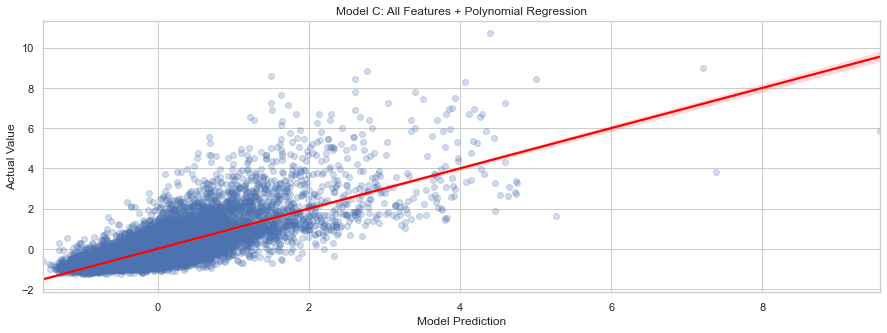

In [2511]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model C: All Features + Polynomial Regression')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_C_regplot')

## Rank Features for Model C

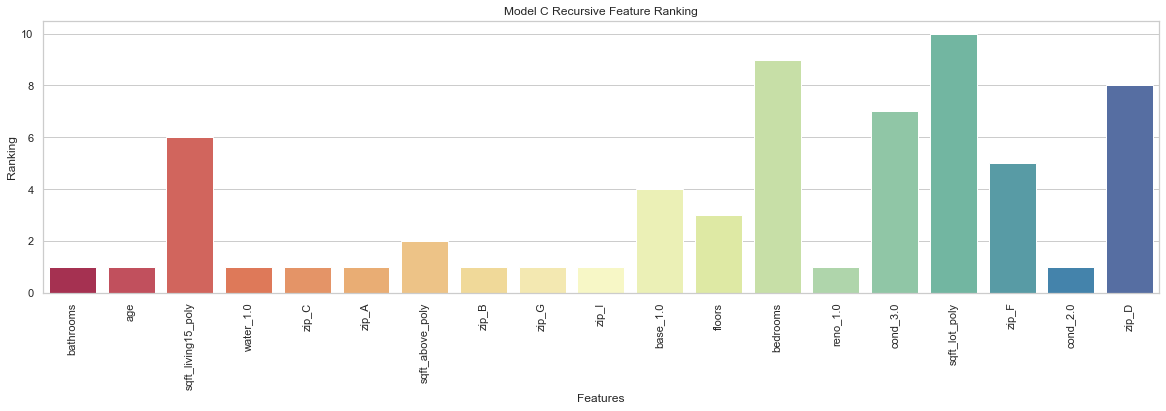

<Figure size 432x288 with 0 Axes>

In [2512]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_C], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_C].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model C Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_C_recursive_features_elimination')


## Test Model C

In [2513]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_C].values, i) for i in range(X[result_C].shape[1])] 
list(zip(result_C, vif))

[('bathrooms', 23.764850068690603),
 ('age', 2.0798903827733612),
 ('sqft_living15_poly', 2.034786029796893),
 ('water_1.0', 1.0268412547001378),
 ('zip_C', 1.8630982251486408),
 ('zip_A', 4.03253924604794),
 ('sqft_above_poly', 2.0396871332547724),
 ('zip_B', 1.8788718818306458),
 ('zip_G', 1.638474800672839),
 ('zip_I', 1.1966181268809553),
 ('base_1.0', 2.379495372831195),
 ('floors', 15.228921717421958),
 ('bedrooms', 18.070345813439065),
 ('reno_1.0', 1.1469983140163114),
 ('cond_3.0', 3.4906868851864035),
 ('sqft_lot_poly', 1.013862427388213),
 ('zip_F', 1.465837109594333),
 ('cond_2.0', 1.0202414039182994),
 ('zip_D', 1.4637555345293336)]

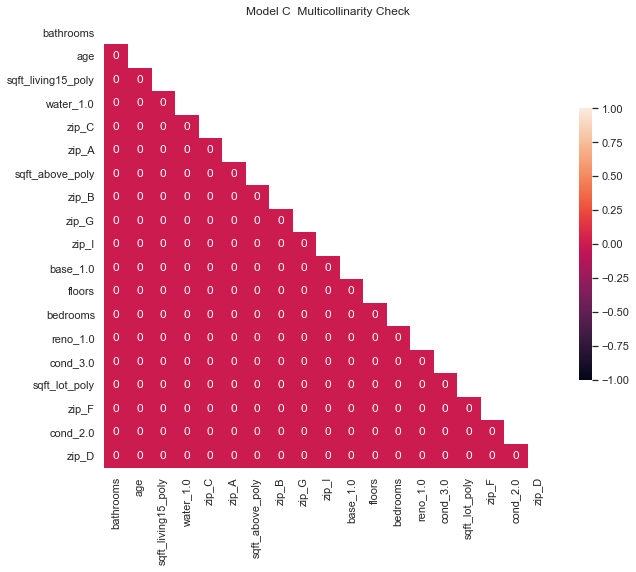

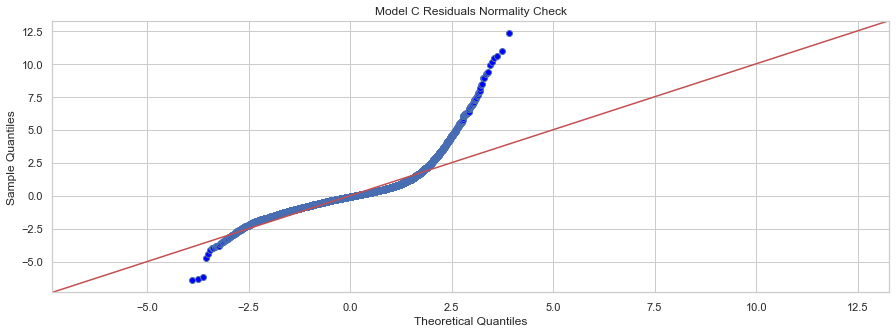

<Figure size 432x288 with 0 Axes>

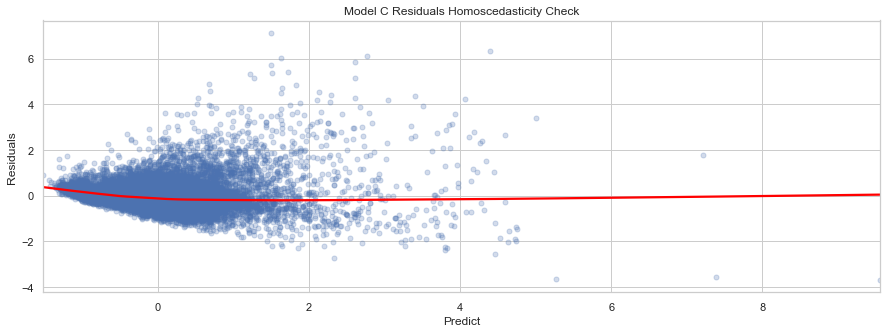

<Figure size 432x288 with 0 Axes>

In [2514]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_C].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_C].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model C  Multicollinarity Check')
plt.savefig('./Data & Figures/model_C_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_C.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model C Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_C.predict(), 
            y = model_C.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha':0.25})
plt.title('Model C Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_C_homoscedasticity_regplot')

In [2515]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_C.resid, model_C.model.exog)
list(zip(name, test))

[('F statistic', 1.1471305582518225), ('p-value', 8.662744383450057e-13)]

In [2516]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_C], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

-0.5795136359817207


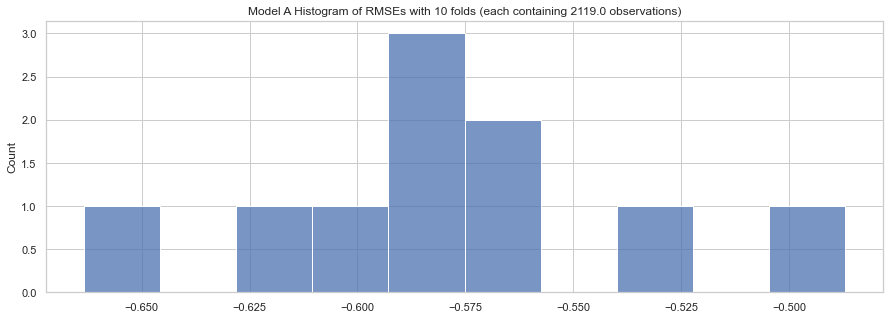

In [2517]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_C) / folds, 0)));
plt.savefig('./Data & Figures/model_C_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model C

In [2518]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_C], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

16950 16950 4238 4238
0.5749447176169188
0.5859855961130669


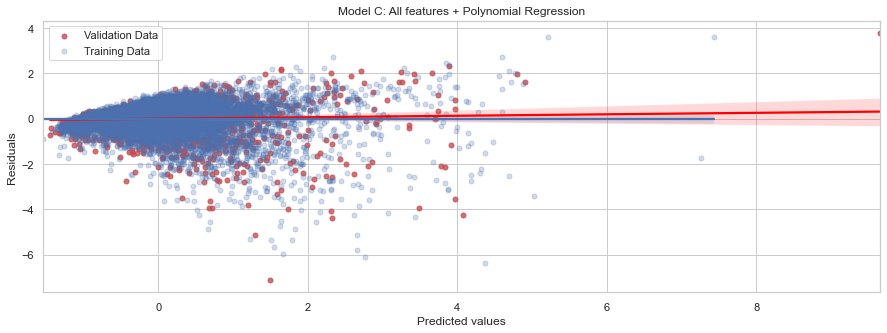

<Figure size 432x288 with 0 Axes>

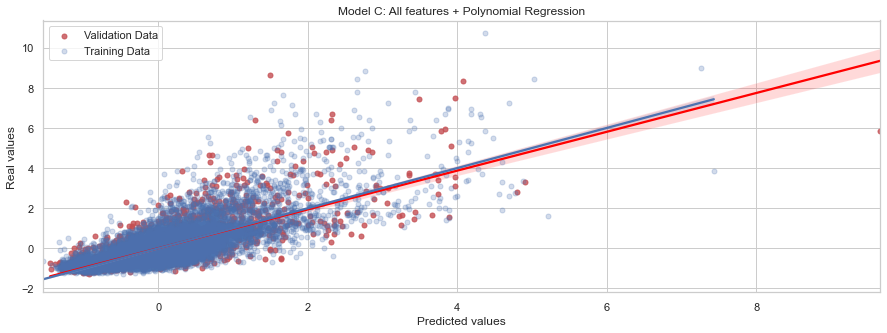

<Figure size 432x288 with 0 Axes>

In [2519]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model C: All features + Polynomial Regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model C: All features + Polynomial Regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_C_predictions_regplot')

In [2520]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 57%'

In [2521]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: -1.2273176280532736 
Train variance: 0.15436160392357512
Test bias: -1.2276591556863221 
Test variance: 0.15529662614985162


In [2522]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_C.pkl','wb'))

In [2523]:
summary_table_1.loc[2] = ['Model C', 'All features + Polynomial Regression', len(result_C), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

Model                           Description   Num Features        r2  \
0  Model A                          All features           19.0  0.668177   
1  Model B   All features, outliers removed, RFE           10.0  0.642821   
2  Model C  All features + Polynomial Regression           19.0  0.585625   

    Accuracy  RMSE Train  RMSE Test  Bias Train  Bias Test  Variance Train  \
0  66.236718    0.562527   0.628671    0.186644   0.179878        0.210681   
1  63.983660    0.535751   0.536075    0.169684   0.163239        0.208434   
2  56.964942    0.574945   0.585986   -1.227318  -1.227659        0.154362   

   Variance Test  Cross Validation Multicollinearity Normality  \
0       0.205261         -0.577799                 P         F   
1       0.209862         -0.536612                 P         F   
2       0.155297         -0.579514                 P         F   

  Homoscedasticity  
0                F  
1                F  
2                F

# MODEL D
## log(X)

In [2524]:
preprocessed_log_D = clean[['price', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]
preprocessed_log_D.head()

price  sqft_above_log  sqft_lot_log  sqft_living15_log       age  \
15937 -0.740571       -1.443346      0.011001          -1.932101  0.955962   
20963 -0.384457       -1.390746     -2.297864          -0.818484 -1.357975   
7614  -0.550073       -1.913036     -0.734773          -0.673521  0.989991   
3257  -0.438575       -1.552231     -0.093192           0.075960  1.092076   
16723 -0.479367       -0.044048     -0.724104          -1.400849  1.500418   

       bedrooms  bathrooms  floors  water_1.0  base_1.0  ...  cond_5.0  zip_A  \
15937         3       1.00     1.0          0         1  ...         0      0   
20963         2       1.75     1.5          0         1  ...         0      0   
7614          3       1.00     1.0          0         1  ...         0      1   
3257          2       1.00     1.0          0         1  ...         1      1   
16723         5       2.00     1.5          0         0  ...         0      1   

       zip_B  zip_C  zip_E  zip_D  zip_F  zip_G  zip_H  zip_I  
15937      0      0      1      0      0      0      0      0  
20963      0      0      0      0      0      1      0      0  
7614       0      0      0      0      0      0      0      0  
3257       0      0      0      0      0      0      0      0  
16723      0      0      0      0      0      0      0      0  

[5 rows x 23 columns]

In [2525]:
#drop p-value > 0.05
#drop('water_1.0', axis = 1, inplace = True)

In [2526]:
#drop p-value > 0.05
#preprocessed_log_D.drop('zip_C', axis = 1)

In [2527]:
X = preprocessed_log_D.drop(['price'], axis=1)
y = preprocessed_log_D['price']

In [2528]:
#apply stepwise function
result_D = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_D)

Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  sqft_above_log                 with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  sqft_living15_log              with p-value 2.47836e-282
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  zip_B                          with p-value 2.80582e-179
Add  zip_G                          with p-value 8.83261e-98
Add  base_1.0                       with p-value 2.82616e-91
Add  bedrooms                       with p-value 1.67036e-81
Add  zip_E                          with p-value 1.74756e-17
Add  zip_I                          with p-value 4.51794e-18
Add  sqft_lot_log                   with p-value 3.50448e-13
Add  cond_5.0                       with p-value 5.36105e-09
Add  reno_1.0                       with p-value 5.54751e-07
Add  cond_3.0                       with p-value 1.33909e-05
Add  zip_

## Build Model D

In [2529]:
#build model in statsmodels
#interecept is not included by default and should be added manually
X_in = X[result_D]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_D = sm.OLS(y, X_intercept).fit() 

#get summary
model_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1914.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:27:53   Log-Likelihood:                -20119.
No. Observations:               21420   AIC:                         4.028e+04
Df Residuals:                   21401   BIC:                         4.043e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.8575      0.028    -30.720      0.000      -0.912      -0.803
bathrooms             0.3086      0.010     31.751      0.000       0.290       0.328
age                   0.1668      0.007     25.592      0.000       0.154       0.180
sqft_above_log        0.4154      0.009     46.933      0.000       0.398       0.433
water_1.0             2.4149      0.052     46.204      0.000       2.312       2.517
sqft_living15_log     0.1812      0.007     26.756      0.000       0.168       0.194
zip_A                 0.7798      0.016     50.207      0.000       0.749       0.810
zip_C                 0.8628      0.017     50.764      0.000       0.829       0.896
zip_B                 0.5115      0.016     31.516      0.000       0.480       0.543
zip_G                 0.3944      0.019     21.132      0.000       0.358       0.431
base_1.0              0.2608      0.011     23.264      0.000       0.239       0.283
bedrooms             -0.1131      0.006    -18.550      0.000      -0.125      -0.101
zip_E                 0.1717      0.021      8.348      0.000       0.131       0.212
zip_I                 0.2053      0.028      7.376      0.000       0.151       0.260
sqft_lot_log          0.0373      0.005      6.994      0.000       0.027       0.048
cond_5.0              0.0767      0.017      4.410      0.000       0.043       0.111
reno_1.0              0.1359      0.025      5.535      0.000       0.088       0.184
cond_3.0             -0.0476      0.011     -4.441      0.000      -0.069      -0.027
zip_F                -0.0756      0.019     -4.015      0.000      -0.113      -0.039
==============================================================================
Omnibus:                    20709.411   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3010263.665
Skew:                           4.313   Prob(JB):                         0.00
Kurtosis:                      60.432   Cond. No.                         53.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2530]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_D], y)

#predict yhat using our model
yhat = linreg.predict(X[result_D])
yhat

array([-1.29316773, -0.97428318, -0.62661679, ..., -0.59519044,
       -0.30646373, -0.4144427 ])

In [2531]:
#get intercept
linreg.intercept_

-0.8574728935100254

In [2532]:
#get coefficients and sort them
coefficients_D = dict(zip(X[result_D], list(linreg.coef_)))
dict(sorted(coefficients_D.items(), key = lambda item: item[1]))

{'bedrooms': -0.11314336324895594,
 'zip_F': -0.07560595001614162,
 'cond_3.0': -0.047646674050629265,
 'sqft_lot_log': 0.03728755619619211,
 'cond_5.0': 0.07674074714115449,
 'reno_1.0': 0.13590699028661615,
 'age': 0.16679383742579307,
 'zip_E': 0.1717221632209885,
 'sqft_living15_log': 0.18121155097583908,
 'zip_I': 0.20527433643556575,
 'base_1.0': 0.2608036448099117,
 'bathrooms': 0.30864942661561995,
 'zip_G': 0.3943694887679518,
 'sqft_above_log': 0.4153772284846067,
 'zip_B': 0.5115238943332517,
 'zip_A': 0.7797881166359437,
 'zip_C': 0.862756098472452,
 'water_1.0': 2.4148883615778036}

In [2533]:
lists_D = sorted(coefficients_D.items(), key = lambda item: item[1])
a, b = zip(*lists_D)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model D Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_D_waterfall.png')

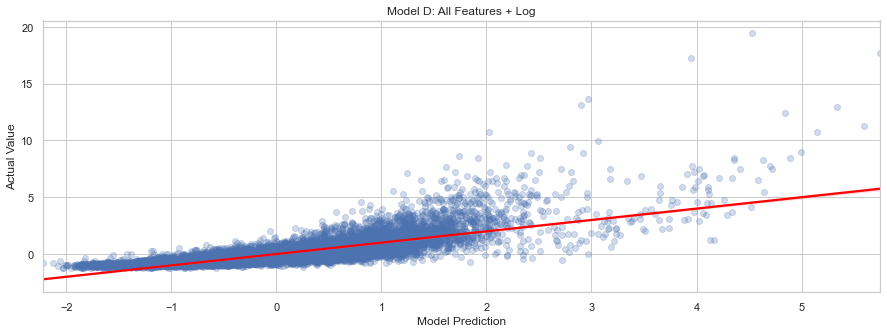

In [2534]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model D: All Features + Log')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_D_scatterplot')

## Rank Features for Model D

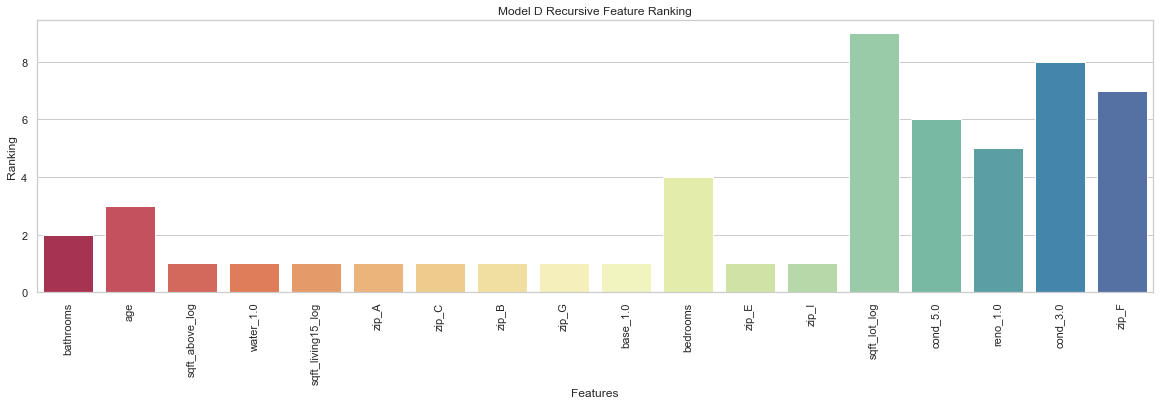

<Figure size 432x288 with 0 Axes>

In [2535]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_D], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_D].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model D Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_D_recursive_features_elimination')

## Test Model D

In [2536]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_D].values, i) for i in range(X[result_D].shape[1])] 
list(zip(result_D, vif))

[('bathrooms', 19.788483900684),
 ('age', 2.3335501530942575),
 ('sqft_above_log', 3.1734686703647794),
 ('water_1.0', 1.0392659653751086),
 ('sqft_living15_log', 2.5560865544367855),
 ('zip_A', 4.181357053003792),
 ('zip_C', 1.8100365557251934),
 ('zip_B', 1.8089106532152488),
 ('zip_G', 1.5604406066106709),
 ('base_1.0', 2.4635663252965196),
 ('bedrooms', 16.459111969678492),
 ('zip_E', 1.4390194066239181),
 ('zip_I', 1.1811730805884697),
 ('sqft_lot_log', 1.5460604428945284),
 ('cond_5.0', 1.3263757032691372),
 ('reno_1.0', 1.1599975785471839),
 ('cond_3.0', 3.8738430114061555),
 ('zip_F', 1.4511657003319696)]

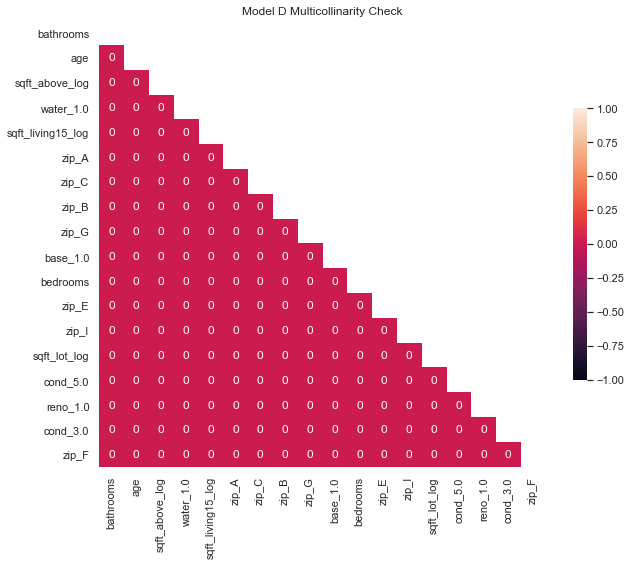

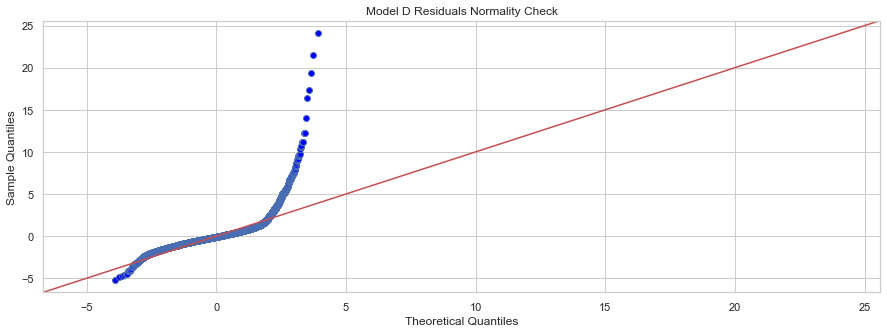

<Figure size 432x288 with 0 Axes>

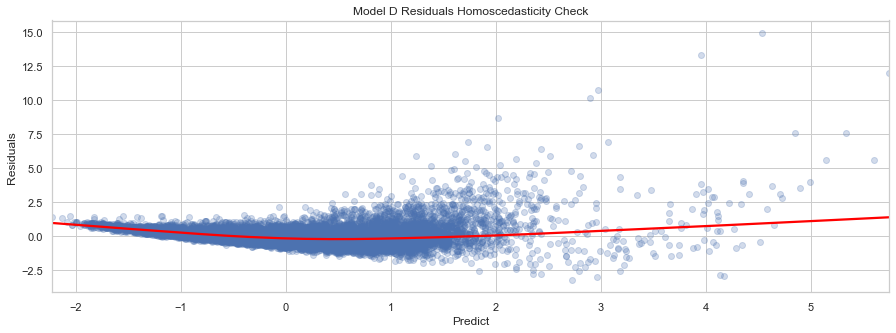

<Figure size 432x288 with 0 Axes>

In [2537]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_D].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_D].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model D Multicollinarity Check')
plt.savefig('./Data & Figures/model_D_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_D.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model D Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_D.predict(), 
            y = model_D.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25}, color = 'r')
plt.title('Model D Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_D_homoscedasticity_regplot')

In [2538]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_D.resid, model_D.model.exog)
list(zip(name, test))

[('F statistic', 1.0033659956380807), ('p-value', 0.43104232776730933)]

-0.6182571710920138


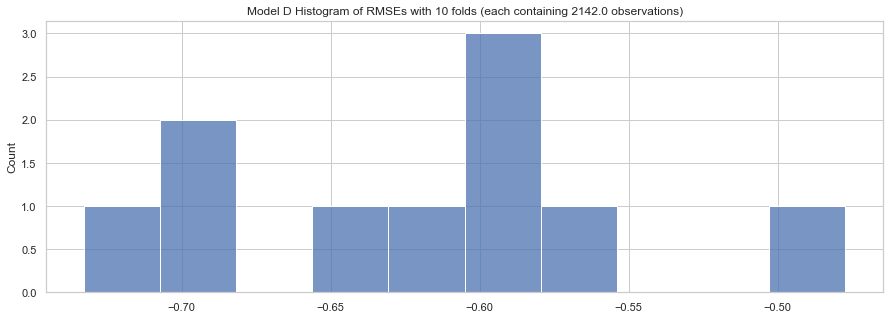

In [2539]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_D], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model D Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_D) / folds, 0)));
plt.savefig('./Data & Figures/model_D_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model D

In [2540]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_D], y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.5999984730497039
0.6912067035032162


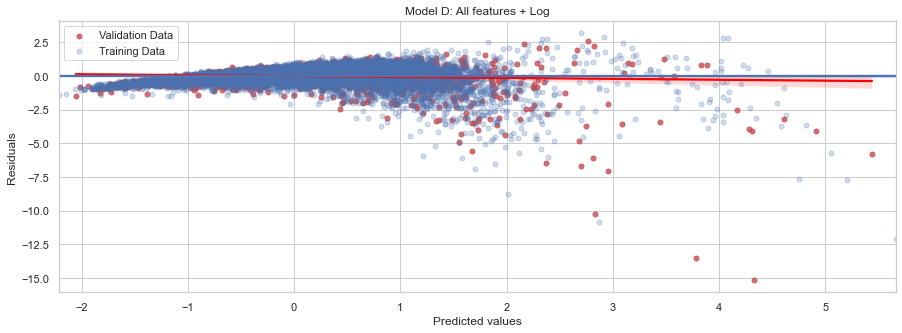

<Figure size 432x288 with 0 Axes>

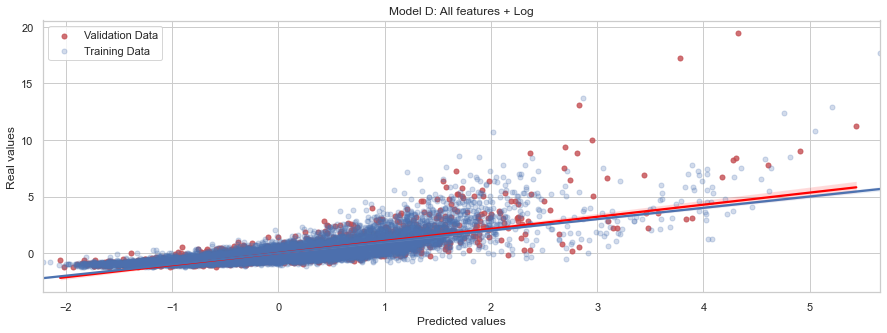

<Figure size 432x288 with 0 Axes>

In [2541]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model D: All features + Log')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model D: All features + Log')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_predictions_regplot')

In [2542]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 59%'

In [2543]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.18109757761216994 
Train variance: 0.2130905077744663
Test bias: 0.17325903317554847 
Test variance: 0.20749552832233412


In [2544]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_D.pkl','wb'))

In [2545]:
#update summary
summary_table_1.loc[3] = ['Model D', 'All features + Log(X)', len(result_D), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

Model                           Description   Num Features        r2  \
0  Model A                          All features           19.0  0.668177   
1  Model B   All features, outliers removed, RFE           10.0  0.642821   
2  Model C  All features + Polynomial Regression           19.0  0.585625   
3  Model D                 All features + Log(X)           18.0  0.616832   

    Accuracy  RMSE Train  RMSE Test  Bias Train  Bias Test  Variance Train  \
0  66.236718    0.562527   0.628671    0.186644   0.179878        0.210681   
1  63.983660    0.535751   0.536075    0.169684   0.163239        0.208434   
2  56.964942    0.574945   0.585986   -1.227318  -1.227659        0.154362   
3  59.185618    0.599998   0.691207    0.181098   0.173259        0.213091   

   Variance Test  Cross Validation Multicollinearity Normality  \
0       0.205261         -0.577799                 P         F   
1       0.209862         -0.536612                 P         F   
2       0.155297         -0.579514                 P         F   
3       0.207496         -0.618257                 P         F   

  Homoscedasticity  
0                F  
1                F  
2                F  
3                F

# MODEL Ea
## Log(y)

In [2546]:
preprocessed_log_Ea = clean[['price_log', 
                            'sqft_above', 'sqft_lot', 'sqft_living15',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_log_Ea.head()

price_log  sqft_above  sqft_lot  sqft_living15       age  bedrooms  \
15937  -1.044412   -1.099527 -0.169225      -1.441766  0.955962         3   
20963  -0.288860   -1.075393 -0.340062      -0.799934 -1.357975         2   
7614   -0.603535   -1.292602 -0.264865      -0.697824  0.989991         3   
3257   -0.386080   -1.147796 -0.186754      -0.085165  1.092076         2   
16723  -0.462787   -0.230689 -0.263901      -1.164611  1.500418         5   

       bathrooms  floors  water_1.0  base_1.0  ...  cond_5.0  zip_A  zip_B  \
15937       1.00     1.0          0         1  ...         0      0      0   
20963       1.75     1.5          0         1  ...         0      0      0   
7614        1.00     1.0          0         1  ...         0      1      0   
3257        1.00     1.0          0         1  ...         1      1      0   
16723       2.00     1.5          0         0  ...         0      1      0   

       zip_C  zip_E  zip_D  zip_F  zip_G  zip_H  zip_I  
15937      0      1      0      0      0      0      0  
20963      0      0      0      0      1      0      0  
7614       0      0      0      0      0      0      0  
3257       0      0      0      0      0      0      0  
16723      0      0      0      0      0      0      0  

[5 rows x 23 columns]

In [2547]:
#specify X_train and y_train
X = preprocessed_log_Ea.drop(['price_log'], axis = 1)
y = preprocessed_log_Ea['price_log']

In [2548]:
#apply function
result_Ea = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_Ea)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  cond_3.0                       with p-value 4.30533e-119
Add  bathrooms                      with p-value 2.75002e-74
Add  age                            with p-value 4.26186e-114
Add  zip_I                          with p-value 1.46825e-70
Add  zip_G                          with p-value 8.19391e-37
Add  cond_2.0                       with p-value 4.05307e-33
Add  sqft_lot                       with p-value 2.04886e-28
Add  reno_1.0                       with p-value 2.19239e-28
Add  bedrooms  

## Build Model Ea

In [2549]:
#build model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_Ea]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_Ea = sm.OLS(y, X_intercept).fit() 

#get summary
model_Ea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     3254.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:28:17   Log-Likelihood:                -15040.
No. Observations:               21420   AIC:                         3.012e+04
Df Residuals:                   21398   BIC:                         3.030e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5792      0.020    -28.824      0.000      -0.619      -0.540
zip_F            -0.7021      0.012    -60.842      0.000      -0.725      -0.679
sqft_above        0.4044      0.007     58.002      0.000       0.391       0.418
zip_A             0.5414      0.009     61.097      0.000       0.524       0.559
base_1.0          0.3319      0.009     36.820      0.000       0.314       0.350
zip_D            -0.5112      0.012    -43.298      0.000      -0.534      -0.488
sqft_living15     0.2543      0.005     46.928      0.000       0.244       0.265
zip_H            -0.5081      0.012    -40.989      0.000      -0.532      -0.484
zip_E            -0.3494      0.013    -27.039      0.000      -0.375      -0.324
water_1.0         1.2578      0.041     30.487      0.000       1.177       1.339
cond_3.0         -0.1149      0.009    -13.455      0.000      -0.132      -0.098
bathrooms         0.1802      0.008     22.970      0.000       0.165       0.196
age               0.0993      0.005     18.836      0.000       0.089       0.110
zip_I            -0.0573      0.019     -3.097      0.002      -0.094      -0.021
zip_G             0.2079      0.011     18.223      0.000       0.186       0.230
cond_2.0         -0.4776      0.039    -12.224      0.000      -0.554      -0.401
sqft_lot          0.0402      0.003     11.484      0.000       0.033       0.047
reno_1.0          0.2030      0.019     10.466      0.000       0.165       0.241
bedrooms         -0.0392      0.005     -8.318      0.000      -0.048      -0.030
zip_B             0.3431      0.009     37.302      0.000       0.325       0.361
zip_C             0.4564      0.010     45.813      0.000       0.437       0.476
floors            0.0674      0.009      7.511      0.000       0.050       0.085
cond_5.0          0.0976      0.014      7.089      0.000       0.071       0.125
==============================================================================
Omnibus:                      623.428   Durbin-Watson:                   1.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1546.263
Skew:                          -0.094   Prob(JB):                         0.00
Kurtosis:                       4.303   Cond. No.                     5.79e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [2550]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_Ea], y)

#predict yhat using our model
yhat = linreg.predict(X[result_Ea])
yhat

array([-1.30473827, -0.60319403, -0.18851094, ..., -0.8865723 ,
       -0.36373195, -0.70523457])

In [2551]:
#get intercept
linreg.intercept_

-0.643571618908602

In [2552]:
#get coefficients and sort them
coefficients_Ea = dict(zip(X[result_Ea], list(linreg.coef_)))
dict(sorted(coefficients_Ea.items(), key = lambda item: item[1]))

{'zip_F': -0.6377169228828197,
 'cond_2.0': -0.47757625182226476,
 'zip_D': -0.4468738621660053,
 'zip_H': -0.4437028945764489,
 'zip_E': -0.2850006552583255,
 'cond_3.0': -0.11486529309904896,
 'bedrooms': -0.0391925574602543,
 'zip_I': 0.007021875813246854,
 'sqft_lot': 0.04019258692808808,
 'floors': 0.06738726882512315,
 'cond_5.0': 0.09761971443355229,
 'age': 0.09930329923174375,
 'bathrooms': 0.18015024208524913,
 'reno_1.0': 0.20301034905938084,
 'sqft_living15': 0.25426610622615115,
 'zip_G': 0.2722359124807962,
 'base_1.0': 0.33187837917959967,
 'sqft_above': 0.40442420858899303,
 'zip_B': 0.40750127574225137,
 'zip_C': 0.5207840596830319,
 'zip_A': 0.6057512111642714,
 'water_1.0': 1.2577994187905557}

In [2553]:
#plot coefficients
lists_Ea = sorted(coefficients_Ea.items(), key = lambda item: item[1])
a, b = zip(*lists_Ea)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model Ea Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_Ea_waterfall.png')

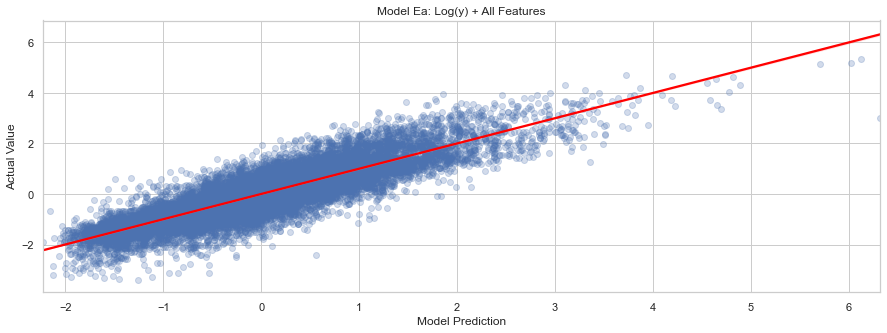

In [2554]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model Ea: Log(y) + All Features')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_Ea_scatterplot')

## Rank Features for Model Ea

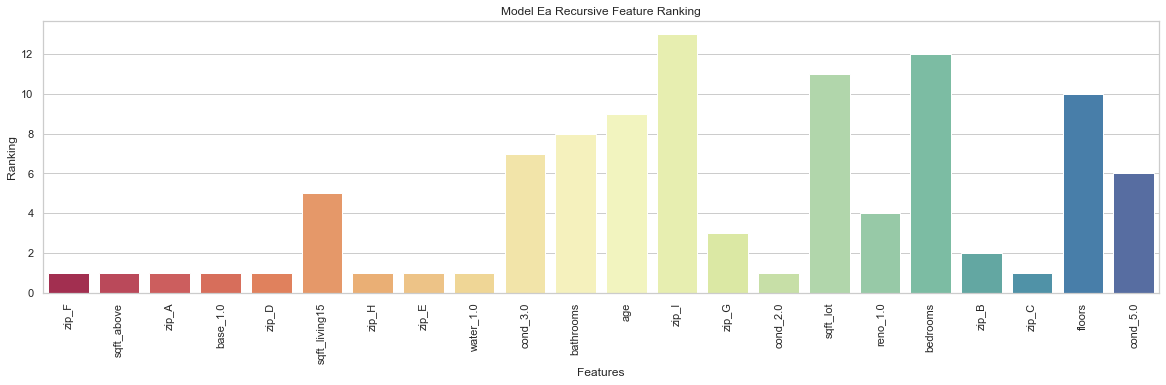

<Figure size 432x288 with 0 Axes>

In [2555]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_Ea], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_Ea].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model Ea Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_Ea_recursive_features_elimination')

## Test Model Ea

In [2556]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_Ea].values, i) for i in range(X[result_Ea].shape[1])] 
list(zip(result_Ea, vif))

[('zip_F', 4.276866368350742),
 ('sqft_above', 4.3627582526567235),
 ('zip_A', 18.913799806010797),
 ('base_1.0', 1.7394253417407661),
 ('zip_D', 4.319128442197981),
 ('sqft_living15', 2.6343973300260557),
 ('zip_H', 3.924820366406429),
 ('zip_E', 3.779061838066185),
 ('water_1.0', 1.0340475383697523),
 ('cond_3.0', 1.4900452902432593),
 ('bathrooms', 3.2618684554872215),
 ('age', 2.494098634468348),
 ('zip_I', 2.2124281674256077),
 ('zip_G', 4.79782402813227),
 ('cond_2.0', 1.0280931571468992),
 ('sqft_lot', 1.0992459956053293),
 ('reno_1.0', 1.1262609188452422),
 ('bedrooms', 1.6246500689922643),
 ('zip_B', 6.615798525603597),
 ('zip_C', 6.170568789792321),
 ('floors', 2.1068830251714536),
 ('cond_5.0', 1.2346787256779514)]

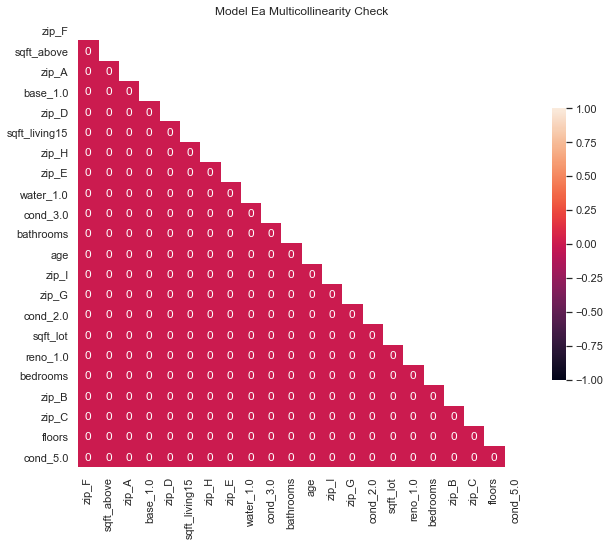

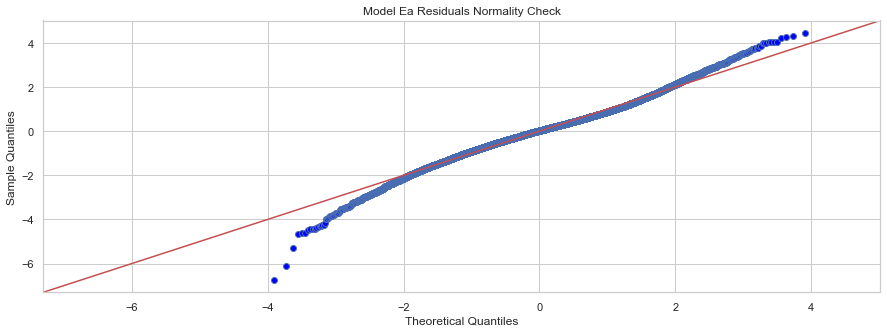

<Figure size 432x288 with 0 Axes>

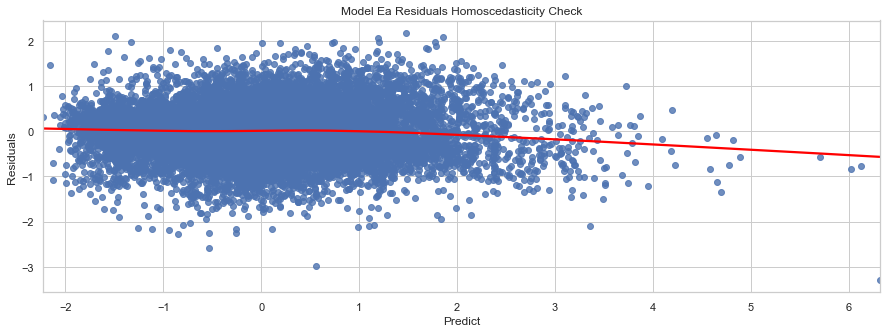

<Figure size 432x288 with 0 Axes>

In [2557]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_Ea].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_Ea].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model Ea Multicollinearity Check')
plt.savefig('./Data & Figures/model_Ea_multicollinearity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_Ea.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model Ea Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_Ea_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_Ea.predict(), 
            y = model_Ea.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model Ea Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_Ea_homoscedasticity_regplot')

In [2558]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_Ea.resid, model_Ea.model.exog)
list(zip(name, test))

[('F statistic', 1.072388366096099), ('p-value', 0.00015182245064107526)]

-0.49094031792151227


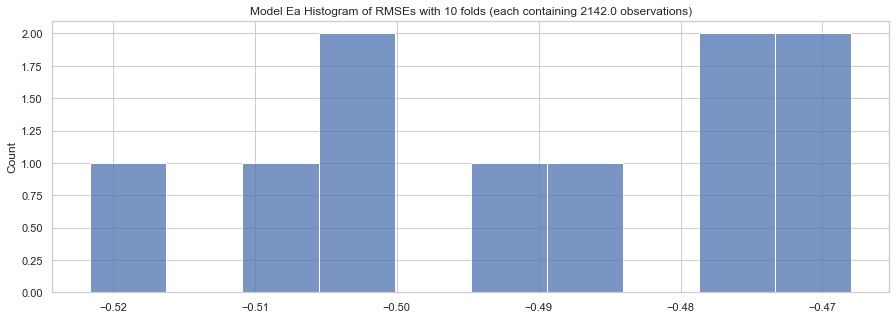

In [2559]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_Ea], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model Ea Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_E) / folds, 0)));
plt.savefig('./Data & Figures/model_Ea_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model Ea

In [2560]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_Ea], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.49052845377272297
0.4796294947149711


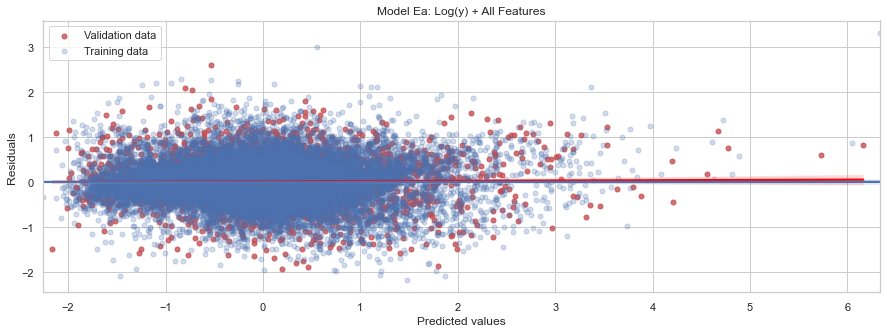

<Figure size 432x288 with 0 Axes>

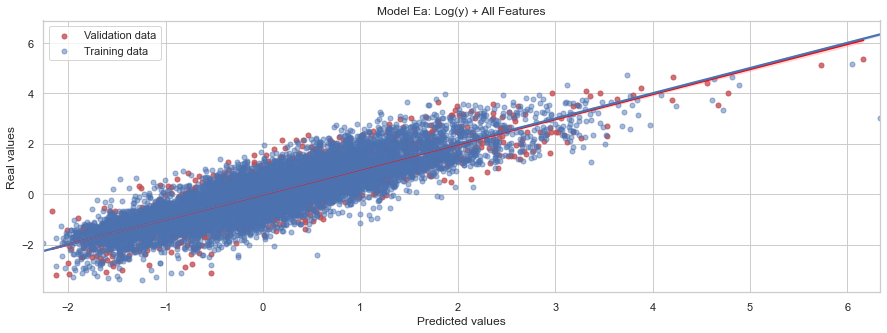

<Figure size 432x288 with 0 Axes>

In [2561]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training data')

plt.title('Model Ea: Log(y) + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_Ea_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25}, 
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {'s': 25,'alpha': 0.5}, fit_reg = True, label = 'Training data')

plt.title('Model Ea: Log(y) + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_Ea_predictions_regplot')

In [2562]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 77%'

In [2563]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: -0.12449976252093252 
Train variance: 0.3005117299889012
Test bias: -0.12008061179454402 
Test variance: 0.2945642082673645


In [2564]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_Ea.pkl','wb'))

In [2565]:
summary_table_1.loc[4] = ['Model Ea', 'Log(y) + All features', len(result_Ea), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_1.head()

Model                           Description   Num Features        r2  \
0   Model A                          All features           19.0  0.668177   
1   Model B   All features, outliers removed, RFE           10.0  0.642821   
2   Model C  All features + Polynomial Regression           19.0  0.585625   
3   Model D                 All features + Log(X)           18.0  0.616832   
4  Model Ea                 Log(y) + All features           22.0  0.761546   

    Accuracy  RMSE Train  RMSE Test  Bias Train  Bias Test  Variance Train  \
0  66.236718    0.562527   0.628671    0.186644   0.179878        0.210681   
1  63.983660    0.535751   0.536075    0.169684   0.163239        0.208434   
2  56.964942    0.574945   0.585986   -1.227318  -1.227659        0.154362   
3  59.185618    0.599998   0.691207    0.181098   0.173259        0.213091   
4  77.329107    0.490528   0.479629   -0.124500  -0.120081        0.300512   

   Variance Test  Cross Validation Multicollinearity Normality  \
0       0.205261         -0.577799                 P         F   
1       0.209862         -0.536612                 P         F   
2       0.155297         -0.579514                 P         F   
3       0.207496         -0.618257                 P         F   
4       0.294564         -0.490940                 P         P   

  Homoscedasticity  
0                F  
1                F  
2                F  
3                F  
4                P

In [2566]:
#save
summary_table_1.to_csv('./Data & Figures/summary_table_1')

# MODEL Eb
## log(y) + VIF

In [2567]:
preprocessed_log_Eb = clean[['price_log', 
                            'sqft_above', 'sqft_lot', 'sqft_living15',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_log_Eb.head()

price_log  sqft_above  sqft_lot  sqft_living15       age  bedrooms  \
15937  -1.044412   -1.099527 -0.169225      -1.441766  0.955962         3   
20963  -0.288860   -1.075393 -0.340062      -0.799934 -1.357975         2   
7614   -0.603535   -1.292602 -0.264865      -0.697824  0.989991         3   
3257   -0.386080   -1.147796 -0.186754      -0.085165  1.092076         2   
16723  -0.462787   -0.230689 -0.263901      -1.164611  1.500418         5   

       bathrooms  floors  water_1.0  base_1.0  ...  cond_5.0  zip_A  zip_B  \
15937       1.00     1.0          0         1  ...         0      0      0   
20963       1.75     1.5          0         1  ...         0      0      0   
7614        1.00     1.0          0         1  ...         0      1      0   
3257        1.00     1.0          0         1  ...         1      1      0   
16723       2.00     1.5          0         0  ...         0      1      0   

       zip_C  zip_E  zip_D  zip_F  zip_G  zip_H  zip_I  
15937      0      1      0      0      0      0      0  
20963      0      0      0      0      1      0      0  
7614       0      0      0      0      0      0      0  
3257       0      0      0      0      0      0      0  
16723      0      0      0      0      0      0      0  

[5 rows x 23 columns]

In [2568]:
#specify X_train and y_train
X = preprocessed_log_Eb.drop(['price_log'], axis = 1)
y = preprocessed_log_Eb['price_log']

In [2569]:
#apply function
result_Eb = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_Eb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  cond_3.0                       with p-value 4.30533e-119
Add  bathrooms                      with p-value 2.75002e-74
Add  age                            with p-value 4.26186e-114
Add  zip_I                          with p-value 1.46825e-70
Add  zip_G                          with p-value 8.19391e-37
Add  cond_2.0                       with p-value 4.05307e-33
Add  sqft_lot                       with p-value 2.04886e-28
Add  reno_1.0                       with p-value 2.19239e-28
Add  bedrooms  

In [2570]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_Eb].values, i) for i in range(X[result_Eb].shape[1])] 
list(zip(result_Eb, vif))

[('zip_F', 4.276866368350742),
 ('sqft_above', 4.3627582526567235),
 ('zip_A', 18.913799806010797),
 ('base_1.0', 1.7394253417407661),
 ('zip_D', 4.319128442197981),
 ('sqft_living15', 2.6343973300260557),
 ('zip_H', 3.924820366406429),
 ('zip_E', 3.779061838066185),
 ('water_1.0', 1.0340475383697523),
 ('cond_3.0', 1.4900452902432593),
 ('bathrooms', 3.2618684554872215),
 ('age', 2.494098634468348),
 ('zip_I', 2.2124281674256077),
 ('zip_G', 4.79782402813227),
 ('cond_2.0', 1.0280931571468992),
 ('sqft_lot', 1.0992459956053293),
 ('reno_1.0', 1.1262609188452422),
 ('bedrooms', 1.6246500689922643),
 ('zip_B', 6.615798525603597),
 ('zip_C', 6.170568789792321),
 ('floors', 2.1068830251714536),
 ('cond_5.0', 1.2346787256779514)]

In [2571]:
#drop vif > 10
preprocessed_log_Eb.drop('zip_A', axis = 1, inplace = True)

#redefine X_train and y_train
X = preprocessed_log_Eb.drop(['price_log'], axis = 1)
y = preprocessed_log_Eb['price_log']

In [2572]:
#apply function
result_Eb = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_Eb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  zip_E                          with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  sqft_living15                  with p-value 5.6677e-302
Add  water_1.0                      with p-value 5.85106e-223
Add  age                            with p-value 6.11007e-191
Add  bathrooms                      with p-value 1.03358e-169
Add  zip_I                          with p-value 1.78166e-100
Add  zip_G                          with p-value 1.52324e-72
Add  zip_B                          with p-value 1.31505e-54
Add  cond_3.0                       with p-value 2.60517e-30
Add  cond_2.0                       with p-value 4.09924e-32
Add  sqft_lot                       with p-value 2.35756e-29
Add  floors                         with p-value 6.54912e-27
Add  re

In [2573]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_Eb].values, i) for i in range(X[result_Eb].shape[1])] 
list(zip(result_Eb, vif))

[('zip_F', 1.3435452711913658),
 ('sqft_above', 3.2689997954665753),
 ('base_1.0', 2.8619156743059966),
 ('zip_D', 1.2976635284127236),
 ('zip_E', 1.20890902412992),
 ('zip_H', 1.3865785638432333),
 ('sqft_living15', 2.6321844909993857),
 ('water_1.0', 1.0407324150376414),
 ('age', 1.9490753057983723),
 ('bathrooms', 24.626811831853452),
 ('zip_I', 1.1677048415479703),
 ('zip_G', 1.5084792766962354),
 ('zip_B', 1.6303884372228445),
 ('cond_3.0', 3.925060756581659),
 ('cond_2.0', 1.0322263591743674),
 ('sqft_lot', 1.0949625026557668),
 ('floors', 13.127610065117988),
 ('reno_1.0', 1.151536617084993),
 ('bedrooms', 19.23031858412227),
 ('cond_5.0', 1.3364050852712206),
 ('zip_C', 1.6571240450406488)]

In [2574]:
#drop vif > 10
preprocessed_log_Eb.drop('floors', axis = 1, inplace = True)

#redefine X_train and y_train
X = preprocessed_log_Eb.drop(['price_log'], axis = 1)
y = preprocessed_log_Eb['price_log']

In [2575]:
#apply function
result_Eb = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_Eb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  zip_E                          with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  sqft_living15                  with p-value 5.6677e-302
Add  water_1.0                      with p-value 5.85106e-223
Add  age                            with p-value 6.11007e-191
Add  bathrooms                      with p-value 1.03358e-169
Add  zip_I                          with p-value 1.78166e-100
Add  zip_G                          with p-value 1.52324e-72
Add  zip_B                          with p-value 1.31505e-54
Add  cond_3.0                       with p-value 2.60517e-30
Add  cond_2.0                       with p-value 4.09924e-32
Add  sqft_lot                       with p-value 2.35756e-29
Add  reno_1.0                       with p-value 1.26939e-24
Add  zi

In [2576]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_Eb].values, i) for i in range(X[result_Eb].shape[1])] 
list(zip(result_Eb, vif))

[('zip_F', 1.3297800874052923),
 ('sqft_above', 3.261930221679988),
 ('base_1.0', 2.558716381217808),
 ('zip_D', 1.2842415371389717),
 ('zip_E', 1.201093985511186),
 ('zip_H', 1.3809048332408966),
 ('sqft_living15', 2.5933735592609075),
 ('water_1.0', 1.039668829794251),
 ('age', 1.9384499954233265),
 ('bathrooms', 18.420154454710815),
 ('zip_I', 1.1662773533812536),
 ('zip_G', 1.5072149711452707),
 ('zip_B', 1.6108954036603564),
 ('cond_3.0', 3.6524491600423654),
 ('cond_2.0', 1.0300423218129333),
 ('sqft_lot', 1.092592609559321),
 ('reno_1.0', 1.151343378790774),
 ('zip_C', 1.634771618695411),
 ('bedrooms', 17.90470101779719),
 ('cond_5.0', 1.332866904828187)]

In [2577]:
#drop vif > 10
preprocessed_log_Eb.drop('bedrooms', axis = 1, inplace = True)

#redefine X_train and y_train
X = preprocessed_log_Eb.drop(['price_log'], axis = 1)
y = preprocessed_log_Eb['price_log']

In [2578]:
#apply function
result_Eb = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_Eb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  zip_E                          with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  sqft_living15                  with p-value 5.6677e-302
Add  water_1.0                      with p-value 5.85106e-223
Add  age                            with p-value 6.11007e-191
Add  bathrooms                      with p-value 1.03358e-169
Add  zip_I                          with p-value 1.78166e-100
Add  zip_G                          with p-value 1.52324e-72
Add  zip_B                          with p-value 1.31505e-54
Add  cond_3.0                       with p-value 2.60517e-30
Add  cond_2.0                       with p-value 4.09924e-32
Add  sqft_lot                       with p-value 2.35756e-29
Add  reno_1.0                       with p-value 1.26939e-24
Add  zi

In [2579]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_Eb].values, i) for i in range(X[result_Eb].shape[1])] 
list(zip(result_Eb, vif))

[('zip_F', 1.244207153973557),
 ('sqft_above', 3.259682052372057),
 ('base_1.0', 2.5313845450614614),
 ('zip_D', 1.2113656388227736),
 ('zip_E', 1.1628210771939527),
 ('zip_H', 1.3074049847770346),
 ('sqft_living15', 2.565085447510834),
 ('water_1.0', 1.0351220703176571),
 ('age', 1.579173733620859),
 ('bathrooms', 8.417726956792826),
 ('zip_I', 1.145278431366168),
 ('zip_G', 1.4440626215265644),
 ('zip_B', 1.5030130783937563),
 ('cond_3.0', 3.5138068083263154),
 ('cond_2.0', 1.0295809491634558),
 ('sqft_lot', 1.0872356460815802),
 ('reno_1.0', 1.137251459576252),
 ('zip_C', 1.489583483868603),
 ('cond_5.0', 1.33022730327929)]

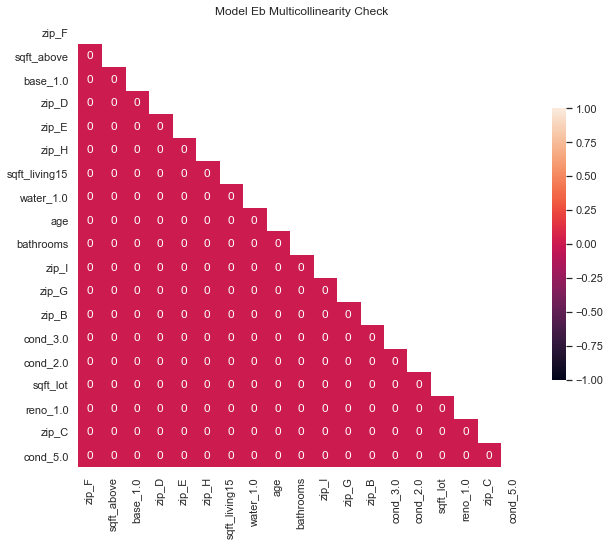

In [2580]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_Eb].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_Eb].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model Eb Multicollinearity Check')
plt.savefig('./Data & Figures/model_Eb_multicollinearity_check')

## Build Model Eb

In [2581]:
#build model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_Eb]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_Eb = sm.OLS(y, X_intercept).fit() 

#get summary
model_Eb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     3568.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:28:49   Log-Likelihood:                -15105.
No. Observations:               21420   AIC:                         3.025e+04
Df Residuals:                   21400   BIC:                         3.041e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0320      0.018     -1.771      0.077      -0.067       0.003
zip_F            -1.2827      0.014    -91.402      0.000      -1.310      -1.255
sqft_above        0.4016      0.007     61.037      0.000       0.389       0.415
base_1.0          0.2999      0.009     34.977      0.000       0.283       0.317
zip_D            -1.0902      0.014    -78.343      0.000      -1.117      -1.063
zip_E            -0.9209      0.015    -62.847      0.000      -0.950      -0.892
zip_H            -1.0846      0.015    -70.717      0.000      -1.115      -1.055
sqft_living15     0.2527      0.005     46.731      0.000       0.242       0.263
water_1.0         1.2894      0.041     31.249      0.000       1.209       1.370
age               0.0808      0.005     16.223      0.000       0.071       0.091
bathrooms         0.1768      0.007     23.702      0.000       0.162       0.191
zip_I            -0.6278      0.022    -28.781      0.000      -0.671      -0.585
zip_G            -0.3593      0.014    -24.976      0.000      -0.388      -0.331
zip_B            -0.2326      0.012    -19.472      0.000      -0.256      -0.209
cond_3.0         -0.1080      0.009    -12.654      0.000      -0.125      -0.091
cond_2.0         -0.4686      0.039    -11.962      0.000      -0.545      -0.392
sqft_lot          0.0405      0.003     11.612      0.000       0.034       0.047
reno_1.0          0.2172      0.019     11.187      0.000       0.179       0.255
zip_C            -0.1257      0.013    -10.018      0.000      -0.150      -0.101
cond_5.0          0.0991      0.014      7.173      0.000       0.072       0.126
==============================================================================
Omnibus:                      609.959   Durbin-Watson:                   1.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1493.722
Skew:                          -0.093   Prob(JB):                         0.00
Kurtosis:                       4.280   Cond. No.                         32.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2582]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_Eb], y)

#predict yhat using our model
yhat = linreg.predict(X[result_Eb])
yhat

array([-1.31987474, -0.64773617, -0.18156211, ..., -0.86847528,
       -0.35080787, -0.63120717])

In [2583]:
#get intercept
linreg.intercept_

-0.032026872381624626

In [2584]:
#get coefficients and sort them
coefficients_Eb = dict(zip(X[result_Eb], list(linreg.coef_)))
dict(sorted(coefficients_Eb.items(), key = lambda item: item[1]))

{'zip_F': -1.282674986720365,
 'zip_D': -1.0901565331867957,
 'zip_H': -1.0846254197285665,
 'zip_E': -0.9209135287937155,
 'zip_I': -0.6277855228903115,
 'cond_2.0': -0.4686237722322115,
 'zip_G': -0.35931648041065634,
 'zip_B': -0.2325672142796949,
 'zip_C': -0.1256787042245474,
 'cond_3.0': -0.10803749545685494,
 'sqft_lot': 0.04054308794756113,
 'age': 0.08084001257505245,
 'cond_5.0': 0.09906668493078688,
 'bathrooms': 0.17681496821283754,
 'reno_1.0': 0.2172126404665435,
 'sqft_living15': 0.25274892766702606,
 'base_1.0': 0.2998630548617842,
 'sqft_above': 0.401617404271894,
 'water_1.0': 1.2893849790713015}

In [2585]:
#plot coefficients
lists_Eb = sorted(coefficients_Eb.items(), key = lambda item: item[1])
a, b = zip(*lists_Eb)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model Eb Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_Eb_waterfall.png')

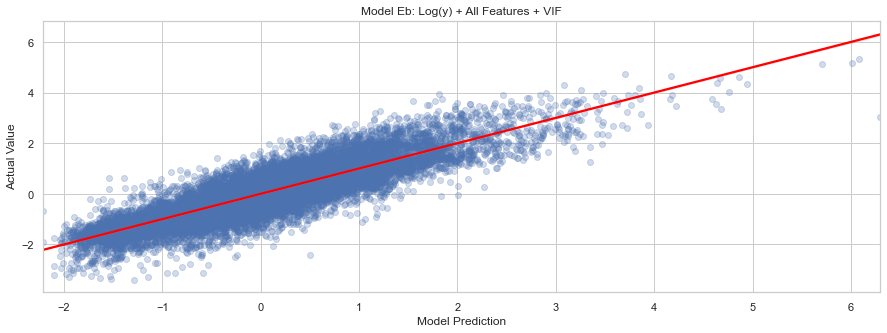

In [2586]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model Eb: Log(y) + All Features + VIF')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_Eb_scatterplot')

## Rank Features for Model Eb

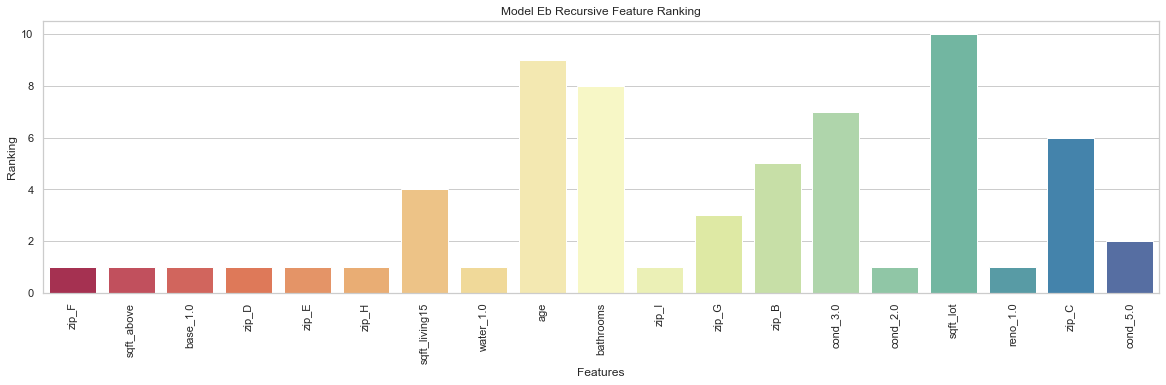

<Figure size 432x288 with 0 Axes>

In [2587]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_Eb], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_Eb].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model Eb Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_Eb_recursive_features_elimination')

## Test Model Eb

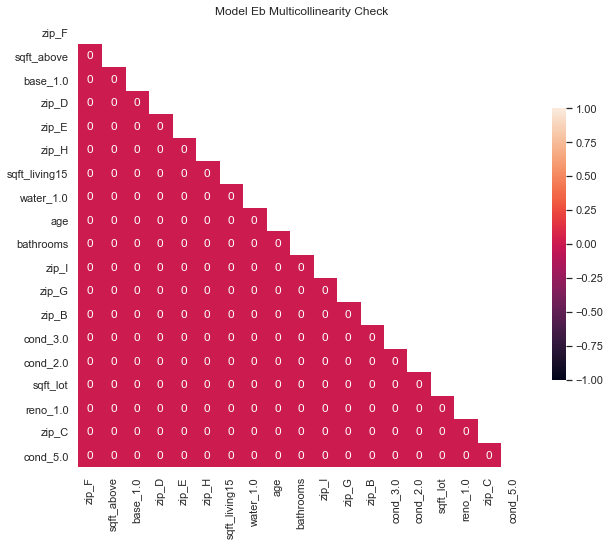

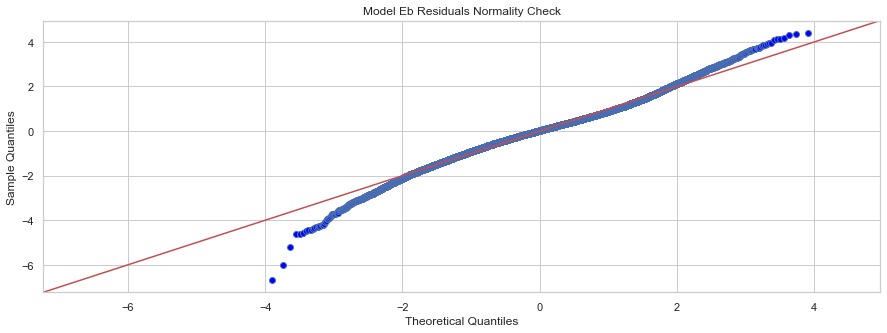

<Figure size 432x288 with 0 Axes>

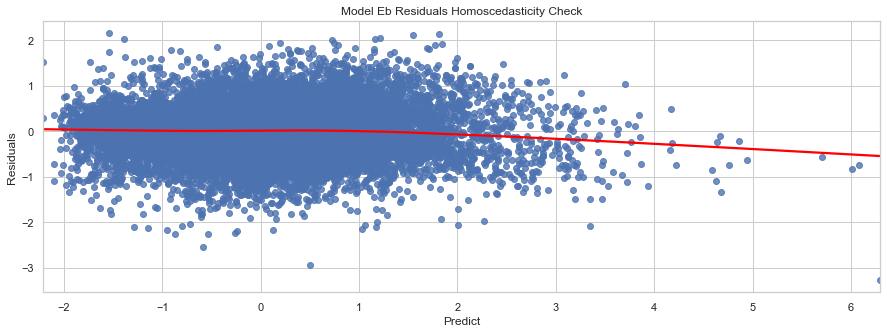

<Figure size 432x288 with 0 Axes>

In [2588]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_Eb].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_Eb].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model Eb Multicollinearity Check')
plt.savefig('./Data & Figures/model_Eb_multicollinearity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_Eb.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model Eb Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_Eb_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_Eb.predict(), 
            y = model_Eb.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model Eb Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_Eb_homoscedasticity_regplot')

In [2589]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_Eb.resid, model_Eb.model.exog)
list(zip(name, test))

[('F statistic', 1.0689802909184687), ('p-value', 0.00028236995414514644)]

-0.4923638380853953


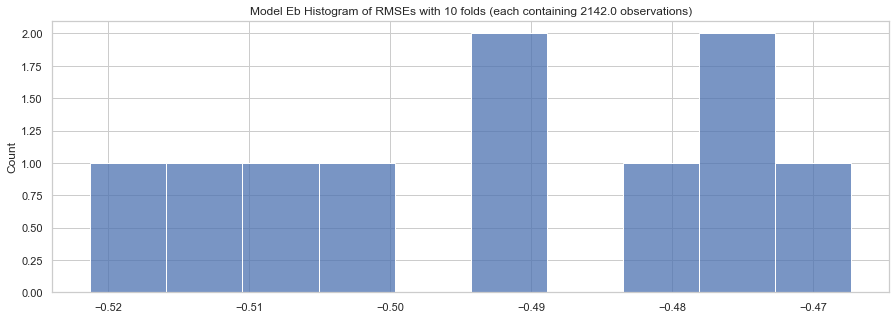

In [2590]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_Eb], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model Eb Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_Eb) / folds, 0)));
plt.savefig('./Data & Figures/model_Eb_cv_result_histplot')

## Validate Model Eb

In [2591]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_Eb], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.4921347055894522
0.4806889403601633


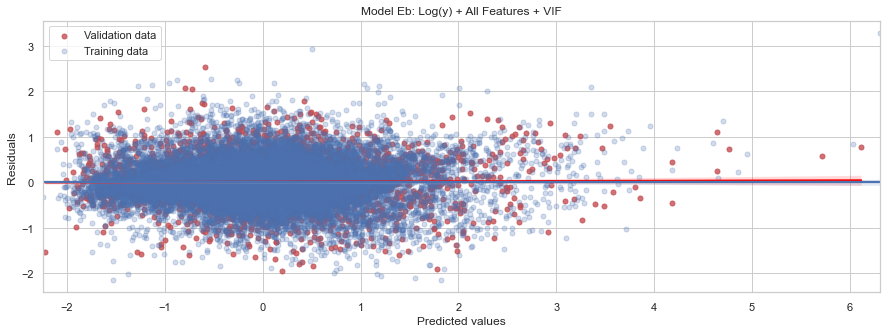

<Figure size 432x288 with 0 Axes>

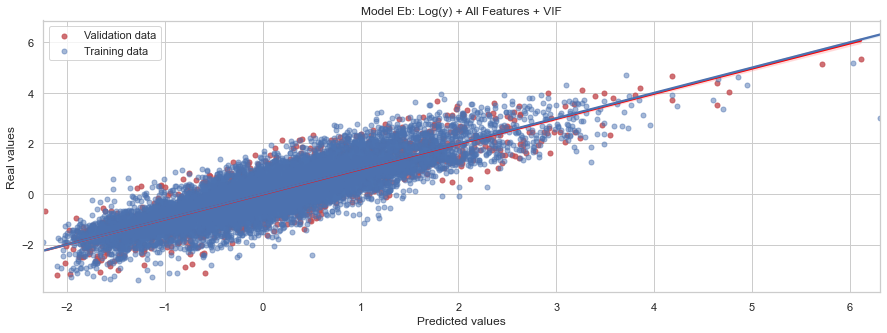

<Figure size 432x288 with 0 Axes>

In [2592]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training data')

plt.title('Model Eb: Log(y) + All Features + VIF')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_Eb_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25}, 
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {'s': 25,'alpha': 0.5}, fit_reg = True, label = 'Training data')

plt.title('Model Eb: Log(y) + All Features + VIF')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_Eb_predictions_regplot')

In [2593]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 77%'

In [2594]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: -0.17040983949146926 
Train variance: 0.3012389647157548
Test bias: -0.16657543739477493 
Test variance: 0.2948487917585595


In [2595]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_Eb.pkl','wb'))

In [2596]:
summary_table_1.loc[5] = ['Model Eb', 'Log(y) + All features + VIF', len(result_Eb), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_1.head(10)

Model                           Description   Num Features        r2  \
0   Model A                          All features           19.0  0.668177   
1   Model B   All features, outliers removed, RFE           10.0  0.642821   
2   Model C  All features + Polynomial Regression           19.0  0.585625   
3   Model D                 All features + Log(X)           18.0  0.616832   
4  Model Ea                 Log(y) + All features           22.0  0.761546   
5  Model Eb           Log(y) + All features + VIF           19.0  0.760082   

    Accuracy  RMSE Train  RMSE Test  Bias Train  Bias Test  Variance Train  \
0  66.236718    0.562527   0.628671    0.186644   0.179878        0.210681   
1  63.983660    0.535751   0.536075    0.169684   0.163239        0.208434   
2  56.964942    0.574945   0.585986   -1.227318  -1.227659        0.154362   
3  59.185618    0.599998   0.691207    0.181098   0.173259        0.213091   
4  77.329107    0.490528   0.479629   -0.124500  -0.120081        0.300512   
5  77.228842    0.492135   0.480689   -0.170410  -0.166575        0.301239   

   Variance Test  Cross Validation Multicollinearity Normality  \
0       0.205261         -0.577799                 P         F   
1       0.209862         -0.536612                 P         F   
2       0.155297         -0.579514                 P         F   
3       0.207496         -0.618257                 P         F   
4       0.294564         -0.490940                 P         P   
5       0.294849         -0.492364                 P         P   

  Homoscedasticity  
0                F  
1                F  
2                F  
3                F  
4                P  
5                P

# MODEL Fa
## Interactions 

In [2597]:
preprocessed_log_Fa = clean[['price_log', 
                            'sqft_above', 'sqft_lot', 'sqft_living15',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_log_Fa.head()

price_log  sqft_above  sqft_lot  sqft_living15       age  bedrooms  \
15937  -1.044412   -1.099527 -0.169225      -1.441766  0.955962         3   
20963  -0.288860   -1.075393 -0.340062      -0.799934 -1.357975         2   
7614   -0.603535   -1.292602 -0.264865      -0.697824  0.989991         3   
3257   -0.386080   -1.147796 -0.186754      -0.085165  1.092076         2   
16723  -0.462787   -0.230689 -0.263901      -1.164611  1.500418         5   

       bathrooms  floors  water_1.0  base_1.0  ...  cond_5.0  zip_A  zip_B  \
15937       1.00     1.0          0         1  ...         0      0      0   
20963       1.75     1.5          0         1  ...         0      0      0   
7614        1.00     1.0          0         1  ...         0      1      0   
3257        1.00     1.0          0         1  ...         1      1      0   
16723       2.00     1.5          0         0  ...         0      1      0   

       zip_C  zip_E  zip_D  zip_F  zip_G  zip_H  zip_I  
15937      0      1      0      0      0      0      0  
20963      0      0      0      0      1      0      0  
7614       0      0      0      0      0      0      0  
3257       0      0      0      0      0      0      0  
16723      0      0      0      0      0      0      0  

[5 rows x 23 columns]

In [2598]:
#define training variables
X = preprocessed_log_Fa.drop(['price_log'], axis = 1)
y = preprocessed_log_Fa['price_log']

In [2599]:
#get baseline model r2
from sklearn.model_selection import KFold

linreg = LinearRegression()

crossvalidation = KFold(n_splits = 10, shuffle = True, random_state =1)

baseline = np.mean(cross_val_score(linreg, X, y, scoring = 'r2', cv = crossvalidation))
baseline

0.7606072097877115

In [2600]:
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(linreg, data, y, scoring='r2', cv = crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 10 interactions: %s' %sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10])

0
50
100
150
200
Top 10 interactions: [('sqft_above', 'sqft_living15', 0.769), ('sqft_living15', 'age', 0.767), ('sqft_living15', 'floors', 0.767), ('sqft_above', 'bedrooms', 0.764), ('sqft_above', 'floors', 0.764), ('sqft_above', 'zip_A', 0.764), ('sqft_living15', 'bathrooms', 0.764), ('sqft_living15', 'cond_3.0', 0.764), ('sqft_living15', 'zip_A', 0.764), ('sqft_above', 'bathrooms', 0.763)]


In [2601]:
#check how many pairs of interaction there are
len(interactions)

139

In [2602]:
sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10]

[('sqft_above', 'sqft_living15', 0.769),
 ('sqft_living15', 'age', 0.767),
 ('sqft_living15', 'floors', 0.767),
 ('sqft_above', 'bedrooms', 0.764),
 ('sqft_above', 'floors', 0.764),
 ('sqft_above', 'zip_A', 0.764),
 ('sqft_living15', 'bathrooms', 0.764),
 ('sqft_living15', 'cond_3.0', 0.764),
 ('sqft_living15', 'zip_A', 0.764),
 ('sqft_above', 'bathrooms', 0.763)]

In [2603]:
#use 10-fold cross-validation to build a model using the above interaction
regression = LinearRegression()
crossvalidation = KFold(n_splits = 10, shuffle = True, random_state = 1)
X_interactions = X.copy()

X_interactions['sqft_above * sqft_living15'] = X_interactions['sqft_above'] * X_interactions['sqft_living15']
X_interactions['sqft_living15 * age'] = X_interactions['sqft_living15'] * X_interactions['age']
X_interactions['sqft_living15 * floors'] = X_interactions['sqft_living15'] * X_interactions['floors']
X_interactions['sqft_above * bedrooms'] = X_interactions['sqft_above'] * X_interactions['bedrooms']
X_interactions['sqft_above * floors'] = X_interactions['sqft_above'] * X_interactions['floors']
X_interactions['sqft_above * zip_A'] = X_interactions['sqft_above'] * X_interactions['zip_A']
X_interactions['sqft_living15 * bathrooms'] = X_interactions['sqft_living15'] * X_interactions['bathrooms']
X_interactions['sqft_living15 * cond_3.0'] = X_interactions['sqft_living15'] * X_interactions['cond_3.0']
X_interactions['sqft_living15 * zip_A'] = X_interactions['sqft_living15'] * X_interactions['zip_A']
X_interactions['sqft_above * bathrooms'] = X_interactions['sqft_above'] * X_interactions['bathrooms']

interaction_model = np.mean(cross_val_score(regression, X_interactions, y, scoring = 'r2', cv = crossvalidation))

interaction_model

0.7736236389793466

In [2604]:
#apply stepwise function
result_Fa = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_Fa)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  sqft_above * sqft_living15     with p-value 3.82919e-169
Add  age                            with p-value 1.58532e-128
Add  bathrooms                      with p-value 2.64118e-111
Add  sqft_living15 * age            with p-value 4.83797e-88
Add  zip_I                          with p-value 2.47503e-66
Add  zip_C                          with p-value 1.59604e-42
Add  bedrooms                       with p-value 1.07544e-42
Add  cond_3.0                       with p-value 3.87895e-34
Add  cond_2.0 

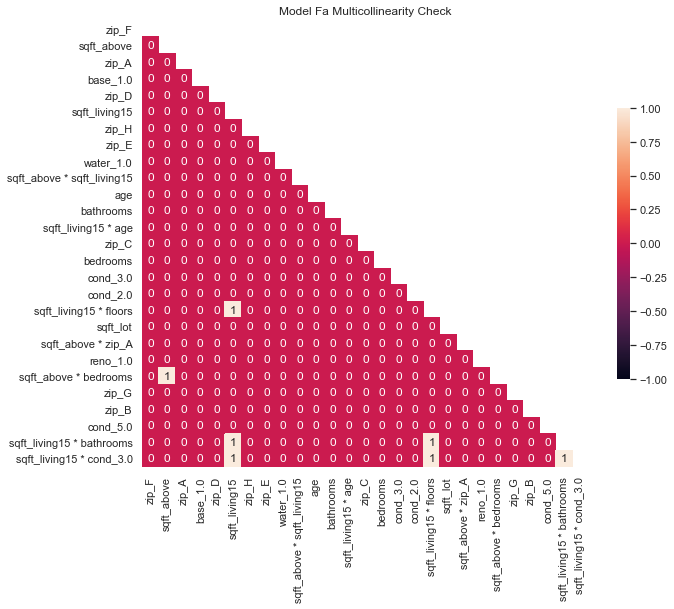

In [2605]:
#check for multicollinearity
mask = np.zeros_like(abs(X_interactions[result_Fa].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions[result_Fa].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model Fa Multicollinearity Check')
plt.savefig('./Data & Figures/model_Fa_multicollinearity_check')

In [2606]:
#that have correlations over .75, but less than 1 
X_interactions_cor = X_interactions.corr().abs().stack().reset_index().sort_values(0, ascending = False)
X_interactions_cor['pairs'] = list(zip(X_interactions_cor['level_0'], X_interactions_cor['level_1']))
X_interactions_cor.set_index(['pairs'], inplace = True)
X_interactions_cor.drop(columns = ['level_0', 'level_1'], inplace = True)

#add correlation column
X_interactions_cor.columns = ['cc']

#drop duplicates
X_interactions_cor.drop_duplicates(inplace = True)

#correlations over .75, but less than 1. = multicollinarity
X_interactions_cor[(X_interactions_cor['cc'] > 0.75) & (X_interactions_cor['cc'] < 1)]

X_interactions_cor.head(15)

cc
pairs                                                       
(sqft_above, sqft_above)                            1.000000
(sqft_above, sqft_above * floors)                   0.970789
(sqft_above * bedrooms, sqft_above)                 0.966156
(sqft_above * floors, sqft_above * bedrooms)        0.961762
(sqft_living15 * floors, sqft_living15)             0.956398
(sqft_above * bedrooms, sqft_above * bathrooms)     0.954756
(sqft_living15 * floors, sqft_living15 * bathro...  0.943060
(sqft_above * bathrooms, sqft_above * floors)       0.941240
(sqft_living15 * bathrooms, sqft_living15)          0.936233
(sqft_above, sqft_above * bathrooms)                0.921942
(sqft_living15 * floors, sqft_living15 * cond_3.0)  0.860944
(sqft_living15, sqft_living15 * cond_3.0)           0.847033
(sqft_living15 * bathrooms, sqft_living15 * con...  0.829517
(sqft_above * floors, sqft_living15 * floors)       0.759448
(sqft_above, sqft_living15 * floors)                0.734778

In [2607]:
#drop multicollinearity
X_interactions.drop(['sqft_living15 * bathrooms', 'sqft_living15 * floors', 'sqft_living15 * cond_3.0',
                     'sqft_above * bathrooms', 'sqft_above * floors', 'sqft_above * bedrooms'], axis = 1, inplace = True)

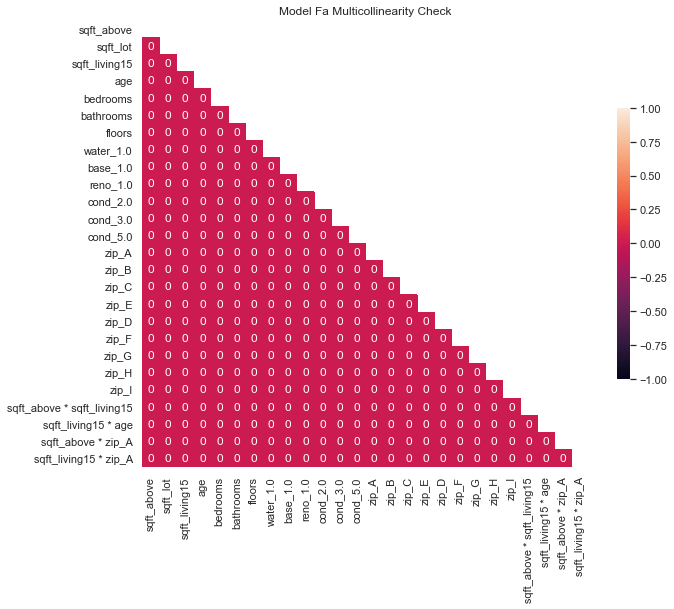

In [2608]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions.corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions.corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model Fa Multicollinearity Check')
plt.savefig('./Data & Figures/model_Fa_multicollinearity_check')

## Re-build Model Fa

In [2609]:
#re-apply stepwise function
result_Fa = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_Fa)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  sqft_above * sqft_living15     with p-value 3.82919e-169
Add  age                            with p-value 1.58532e-128
Add  bathrooms                      with p-value 2.64118e-111
Add  sqft_living15 * age            with p-value 4.83797e-88
Add  zip_I                          with p-value 2.47503e-66
Add  zip_C                          with p-value 1.59604e-42
Add  bedrooms                       with p-value 1.07544e-42
Add  cond_3.0                       with p-value 3.87895e-34
Add  cond_2.0 

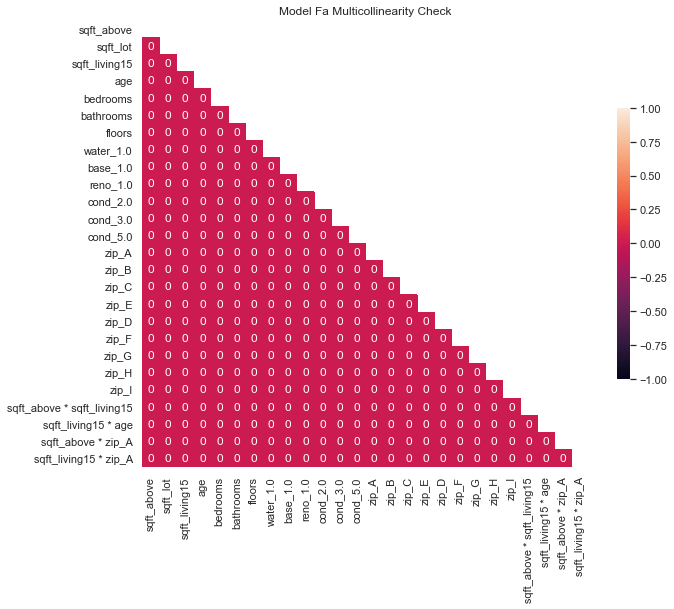

In [2610]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions.corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions.corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model Fa Multicollinearity Check')
plt.savefig('./Data & Figures/model_Fa_multicollinearity_check')

In [2611]:
#build model in statsmodels
X_int = X_interactions[result_Fa]
X_intercept = sm.add_constant(X_int)
model_Fa = sm.OLS(y, X_intercept).fit()

#get summary
model_Fa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     3030.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:29:47   Log-Likelihood:                -14529.
No. Observations:               21420   AIC:                         2.911e+04
Df Residuals:                   21395   BIC:                         2.931e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.3747      0.030    -12.475      0.000      -0.434      -0.316
zip_F                         -0.6801      0.023    -29.583      0.000      -0.725      -0.635
sqft_above                     0.4655      0.008     58.632      0.000       0.450       0.481
zip_A                          0.6101      0.022     27.896      0.000       0.567       0.653
base_1.0                       0.3260      0.009     36.887      0.000       0.309       0.343
zip_D                         -0.4870      0.023    -21.018      0.000      -0.532      -0.442
sqft_living15                  0.2882      0.005     53.233      0.000       0.278       0.299
zip_H                         -0.4839      0.023    -20.807      0.000      -0.529      -0.438
zip_E                         -0.3177      0.024    -13.243      0.000      -0.365      -0.271
water_1.0                      1.2214      0.040     30.259      0.000       1.142       1.300
sqft_above * sqft_living15    -0.0507      0.003    -18.606      0.000      -0.056      -0.045
age                            0.1119      0.005     21.022      0.000       0.101       0.122
bathrooms                      0.1594      0.008     20.736      0.000       0.144       0.174
sqft_living15 * age            0.0507      0.004     11.820      0.000       0.042       0.059
zip_C                          0.4894      0.022     22.137      0.000       0.446       0.533
bedrooms                      -0.0654      0.005    -13.905      0.000      -0.075      -0.056
cond_3.0                      -0.0943      0.008    -11.251      0.000      -0.111      -0.078
cond_2.0                      -0.4365      0.038    -11.431      0.000      -0.511      -0.362
sqft_lot                       0.0343      0.003      9.964      0.000       0.028       0.041
reno_1.0                       0.1569      0.019      8.250      0.000       0.120       0.194
sqft_above * zip_A             0.0707      0.010      7.318      0.000       0.052       0.090
zip_G                          0.2537      0.023     11.271      0.000       0.210       0.298
zip_B                          0.3656      0.022     16.939      0.000       0.323       0.408
cond_5.0                       0.0996      0.013      7.406      0.000       0.073       0.126
floors                         0.0262      0.009      2.960      0.003       0.009       0.044
==============================================================================
Omnibus:                      669.703   Durbin-Watson:                   1.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1644.769
Skew:                          -0.130   Prob(JB):                         0.00
Kurtosis:                       4.332   Cond. No.                         87.0
============================

In [2612]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X_interactions[result_Fa], y)

#predict yhat using our model
yhat = linreg.predict(X_interactions[result_Fa])
yhat

array([-1.44780754, -0.58513346, -0.32261661, ..., -0.75738598,
       -0.25344849, -0.72673158])

In [2613]:
#get intercept
linreg.intercept_

-0.37473726984552413

In [2614]:
#get coefficients and sort them
coefficients_Fa = dict(zip(X_interactions[result_Fa], list(linreg.coef_)))
dict(sorted(coefficients_Fa.items(), key = lambda item: item[1]))

{'zip_F': -0.6801125631647302,
 'zip_D': -0.4870317121770771,
 'zip_H': -0.4838906918309236,
 'cond_2.0': -0.43648333708477194,
 'zip_E': -0.31773310697070156,
 'cond_3.0': -0.09428151162406916,
 'bedrooms': -0.06540390650898782,
 'sqft_above * sqft_living15': -0.050699187668589496,
 'floors': 0.026219082932529676,
 'sqft_lot': 0.03428998255566623,
 'sqft_living15 * age': 0.05070063675249182,
 'sqft_above * zip_A': 0.0707240406110531,
 'cond_5.0': 0.0996217169248045,
 'age': 0.11187314440175082,
 'reno_1.0': 0.15685490581669817,
 'bathrooms': 0.1594219501237656,
 'zip_G': 0.2536668701222355,
 'sqft_living15': 0.28819247283733673,
 'base_1.0': 0.3260030009235828,
 'zip_B': 0.36562626284900446,
 'sqft_above': 0.4655409790795464,
 'zip_C': 0.4893810503644949,
 'zip_A': 0.6100590814642155,
 'water_1.0': 1.2213715646945116}

In [2615]:
lists_Fa = sorted(coefficients_Fa.items(), key = lambda item: item[1])
a, b = zip(*lists_Fa)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model Fa Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_F_waterfall.png')

In [2616]:
#get price_log_med
preprocessed_log_Fa['price_log_med'] = preprocessed_log_Fa['price_log'] > preprocessed_log_Fa['price_log'].median()
preprocessed_log_Fa['price_log_med'] = np.where(preprocessed_log_Fa['price_log_med'] == False, 'Below Median', 'Above Median')

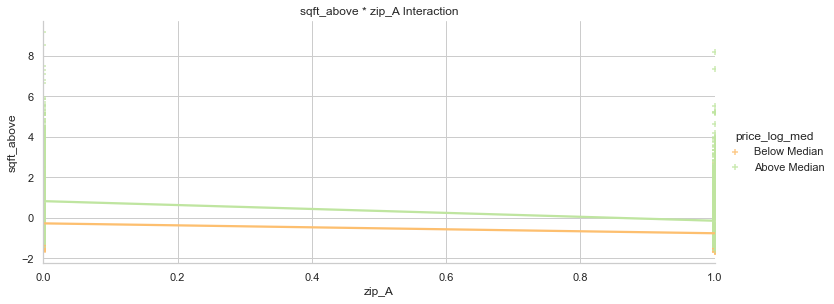

In [2617]:
#plot sqft_above * zip_A interaction
sns.lmplot(x = 'zip_A', y = 'sqft_above', hue = 'price_log_med', 
           data = preprocessed_log_Fa, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_above * zip_A Interaction')
plt.savefig('./Data & Figures/sqft_above * zip_A')

**Observations:**
* zip_A houses are smaller
* Houses in zip_A are high value

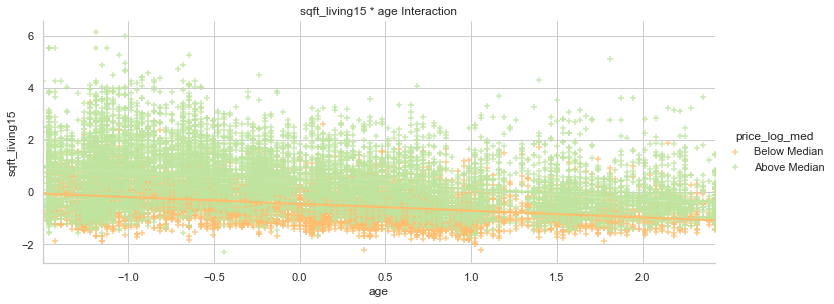

In [2618]:
#plot sqft_living15 * age interaction
sns.lmplot(x = 'age', y = 'sqft_living15', hue = 'price_log_med', 
           data = preprocessed_log_Fa, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_living15 * age Interaction')
plt.savefig('./Data & Figures/sqft_living15 * age')

**Observations:**
* The age of the neighborhood is correlated with the age of the house
* The age of the neighborhood affects the value of a home

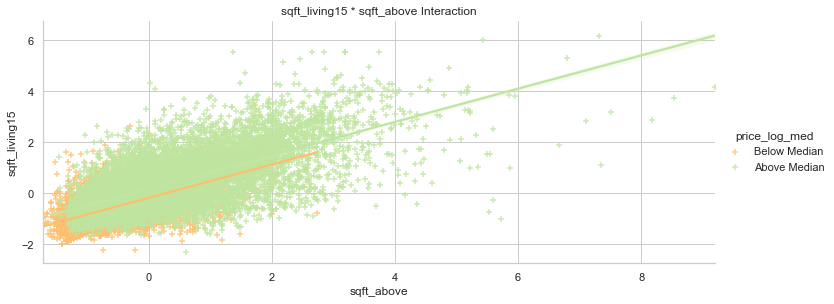

In [2619]:
#plot sqft_living15 * sqft_above interaction
sns.lmplot(x = 'sqft_above', y = 'sqft_living15', hue = 'price_log_med', 
           data = preprocessed_log_Fa, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_living15 * sqft_above Interaction')
plt.savefig('./Data & Figures/sqft_living15 * sqft_above')

**Observations:**
* Houses in the same neighborhood are similar in size

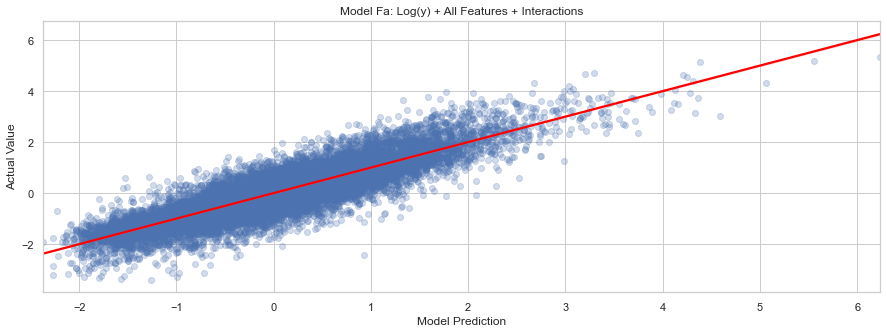

In [2620]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, scatter_kws = {'color':'b','alpha': 0.25}, line_kws = {'color': 'red'})
plt.title('Model Fa: Log(y) + All Features + Interactions')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_Fa_scatterplot')

## Rank Features for Model Fa

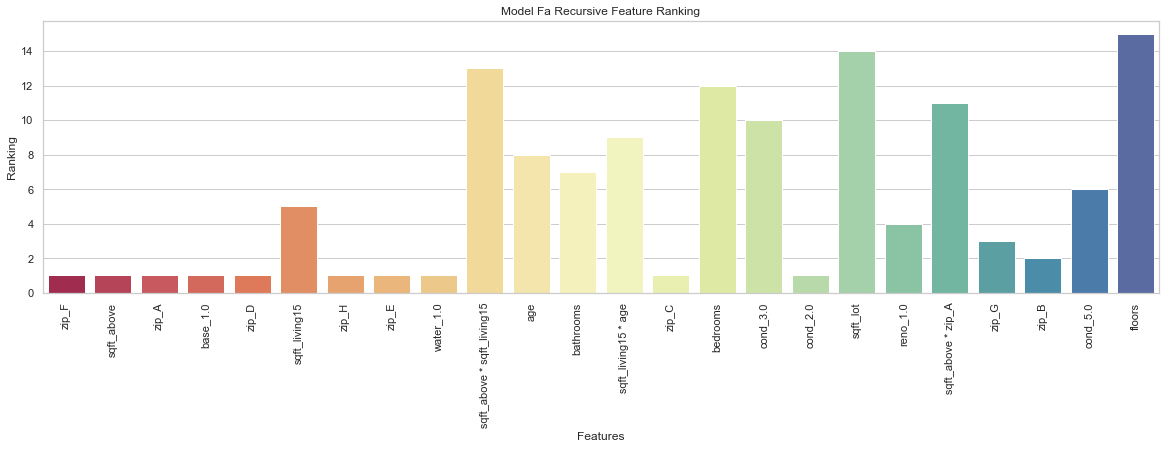

<Figure size 432x288 with 0 Axes>

In [2621]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X_interactions[result_Fa], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X_interactions[result_Fa].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model Fa Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_Fa_recursive_features_elimination')

## Test Model Fa

In [2622]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_Fa].values, i) for i in range(X_interactions[result_Fa].shape[1])] 
list(zip(result_Fa, vif))

[('zip_F', 2.590109828361723),
 ('sqft_above', 5.004010247418782),
 ('zip_A', 10.990498233718567),
 ('base_1.0', 2.8481046673930437),
 ('zip_D', 2.6208158322491273),
 ('sqft_living15', 2.7566868957279347),
 ('zip_H', 2.3899573616403913),
 ('zip_E', 2.4230644216541273),
 ('water_1.0', 1.0446979002525683),
 ('sqft_above * sqft_living15', 2.3038981939268837),
 ('age', 2.5598968510297455),
 ('bathrooms', 25.942750282751827),
 ('sqft_living15 * age', 1.8001521171308617),
 ('zip_C', 3.591067421459065),
 ('bedrooms', 20.755609500256547),
 ('cond_3.0', 4.139582068420148),
 ('cond_2.0', 1.0355275054285276),
 ('sqft_lot', 1.0891676619938864),
 ('reno_1.0', 1.1721736777471705),
 ('sqft_above * zip_A', 2.196273625004701),
 ('zip_G', 2.817213449172302),
 ('zip_B', 3.6868132291240747),
 ('cond_5.0', 1.339199934901794),
 ('floors', 16.1847943004516)]

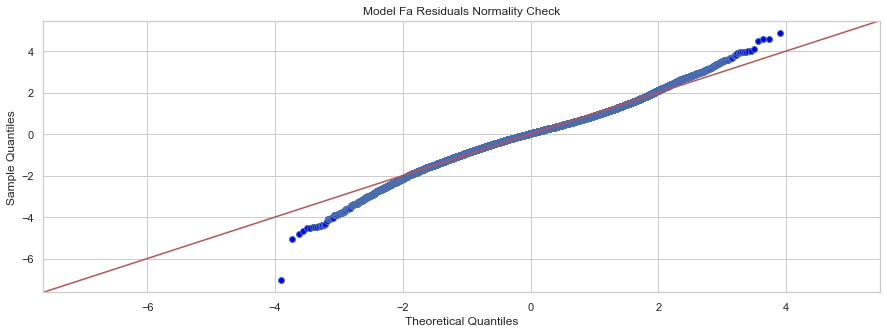

<Figure size 432x288 with 0 Axes>

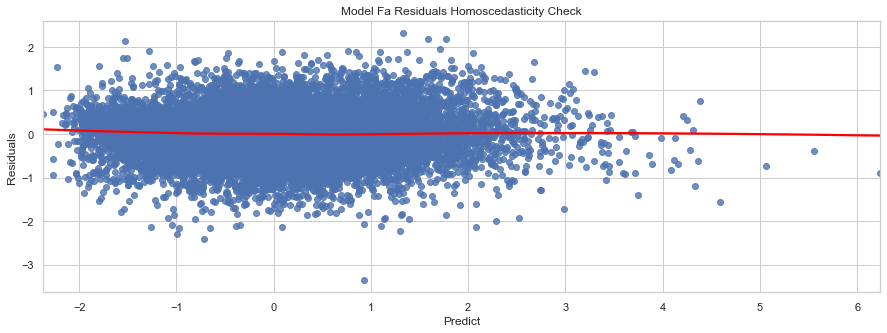

<Figure size 432x288 with 0 Axes>

In [2623]:
#recheck for normality
fig = sm.graphics.qqplot(model_Fa.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model Fa Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_Fa_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_Fa.predict(), 
            y = model_Fa.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model Fa Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_Fa_homoscedasticity_regplot')

In [2624]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_Fa.resid, model_Fa.model.exog)
list(zip(name, test))

[('F statistic', 1.0749758995210443), ('p-value', 9.341919944169217e-05)]

-0.47917488811459047


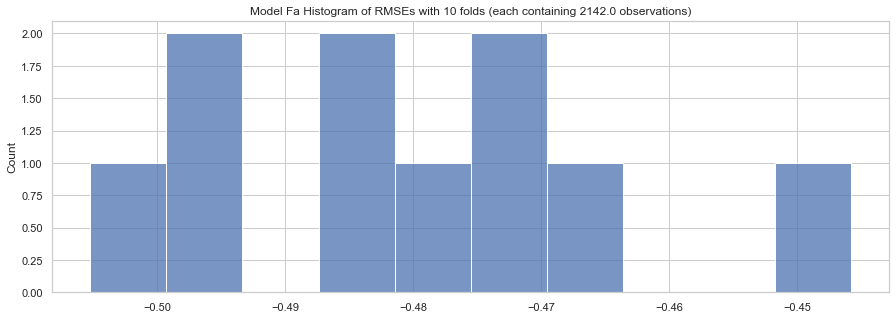

In [2625]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X_interactions[result_Fa], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model Fa Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_F) / folds, 0)));
plt.savefig('./Data & Figures/model_Fa_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model Fa

In [2626]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_interactions[result_Fa], y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.4789625479971112
0.46843242887274045


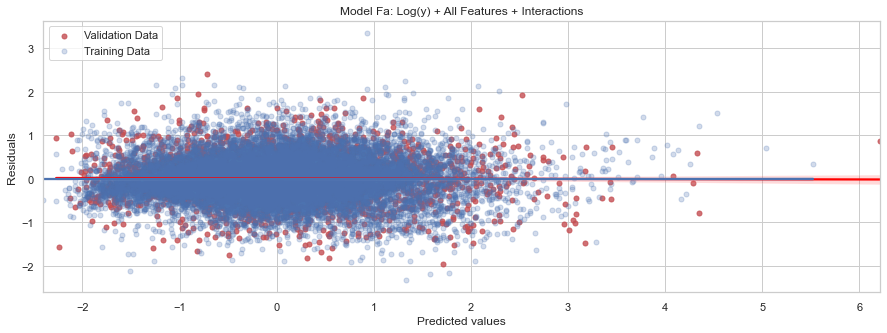

<Figure size 432x288 with 0 Axes>

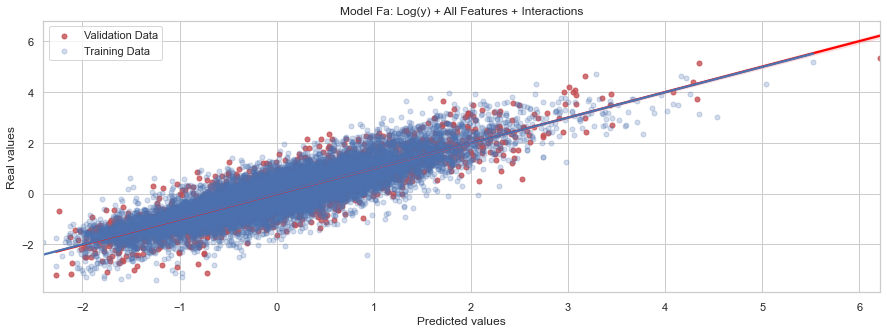

<Figure size 432x288 with 0 Axes>

In [2627]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, fit_reg = True, label = 'Training Data')


plt.title('Model Fa: Log(y) + All Features + Interactions')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_Fa_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, fit_reg = True, label = 'Training Data')

plt.title('Model Fa: Log(y) + All Features + Interactions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_Fa_predictions_regplot')

In [2628]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 78%'

In [2629]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.16220755032457423 
Train variance: 0.3075619180512334
Test bias: 0.16617182105824316 
Test variance: 0.30117557463789857


In [2630]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_Fa.pkl','wb'))

In [2631]:
#update summary
summary_table_1.loc[6] = ['Model Fa', 'Log(y) + All features + Interactions', len(result_Fa) - 2, 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_1.head(10)

Model                           Description   Num Features        r2  \
0   Model A                          All features           19.0  0.668177   
1   Model B   All features, outliers removed, RFE           10.0  0.642821   
2   Model C  All features + Polynomial Regression           19.0  0.585625   
3   Model D                 All features + Log(X)           18.0  0.616832   
4  Model Ea                 Log(y) + All features           22.0  0.761546   
5  Model Eb           Log(y) + All features + VIF           19.0  0.760082   
6  Model Fa  Log(y) + All features + Interactions           22.0  0.772643   

    Accuracy  RMSE Train  RMSE Test  Bias Train  Bias Test  Variance Train  \
0  66.236718    0.562527   0.628671    0.186644   0.179878        0.210681   
1  63.983660    0.535751   0.536075    0.169684   0.163239        0.208434   
2  56.964942    0.574945   0.585986   -1.227318  -1.227659        0.154362   
3  59.185618    0.599998   0.691207    0.181098   0.173259        0.213091   
4  77.329107    0.490528   0.479629   -0.124500  -0.120081        0.300512   
5  77.228842    0.492135   0.480689   -0.170410  -0.166575        0.301239   
6  78.375267    0.478963   0.468432    0.162208   0.166172        0.307562   

   Variance Test  Cross Validation Multicollinearity Normality  \
0       0.205261         -0.577799                 P         F   
1       0.209862         -0.536612                 P         F   
2       0.155297         -0.579514                 P         F   
3       0.207496         -0.618257                 P         F   
4       0.294564         -0.490940                 P         P   
5       0.294849         -0.492364                 P         P   
6       0.301176         -0.479175                 P         P   

  Homoscedasticity  
0                F  
1                F  
2                F  
3                F  
4                P  
5                P  
6                P

# MODEL Fb
# log(y) + Interactions + VIF

In [2632]:
preprocessed_log_Fb = clean[['price_log', 
                            'sqft_above', 'sqft_lot', 'sqft_living15',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_log_Fb.head()

price_log  sqft_above  sqft_lot  sqft_living15       age  bedrooms  \
15937  -1.044412   -1.099527 -0.169225      -1.441766  0.955962         3   
20963  -0.288860   -1.075393 -0.340062      -0.799934 -1.357975         2   
7614   -0.603535   -1.292602 -0.264865      -0.697824  0.989991         3   
3257   -0.386080   -1.147796 -0.186754      -0.085165  1.092076         2   
16723  -0.462787   -0.230689 -0.263901      -1.164611  1.500418         5   

       bathrooms  floors  water_1.0  base_1.0  ...  cond_5.0  zip_A  zip_B  \
15937       1.00     1.0          0         1  ...         0      0      0   
20963       1.75     1.5          0         1  ...         0      0      0   
7614        1.00     1.0          0         1  ...         0      1      0   
3257        1.00     1.0          0         1  ...         1      1      0   
16723       2.00     1.5          0         0  ...         0      1      0   

       zip_C  zip_E  zip_D  zip_F  zip_G  zip_H  zip_I  
15937      0      1      0      0      0      0      0  
20963      0      0      0      0      1      0      0  
7614       0      0      0      0      0      0      0  
3257       0      0      0      0      0      0      0  
16723      0      0      0      0      0      0      0  

[5 rows x 23 columns]

In [2633]:
#define training variables
X = preprocessed_log_Fb.drop(['price_log'], axis = 1)
y = preprocessed_log_Fb['price_log']

In [2634]:
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(linreg, data, y, scoring='r2', cv = crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 10 interactions: %s' %sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10])

0
50
100
150
200
Top 10 interactions: [('sqft_above', 'sqft_living15', 0.769), ('sqft_living15', 'age', 0.767), ('sqft_living15', 'floors', 0.767), ('sqft_above', 'bedrooms', 0.764), ('sqft_above', 'floors', 0.764), ('sqft_above', 'zip_A', 0.764), ('sqft_living15', 'bathrooms', 0.764), ('sqft_living15', 'cond_3.0', 0.764), ('sqft_living15', 'zip_A', 0.764), ('sqft_above', 'bathrooms', 0.763)]


In [2635]:
sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10]

[('sqft_above', 'sqft_living15', 0.769),
 ('sqft_living15', 'age', 0.767),
 ('sqft_living15', 'floors', 0.767),
 ('sqft_above', 'bedrooms', 0.764),
 ('sqft_above', 'floors', 0.764),
 ('sqft_above', 'zip_A', 0.764),
 ('sqft_living15', 'bathrooms', 0.764),
 ('sqft_living15', 'cond_3.0', 0.764),
 ('sqft_living15', 'zip_A', 0.764),
 ('sqft_above', 'bathrooms', 0.763)]

In [2636]:
#use 10-fold cross-validation to build a model using the above interaction
regression = LinearRegression()
crossvalidation = KFold(n_splits = 10, shuffle = True, random_state = 1)
X_interactions = X.copy()

X_interactions['sqft_above * sqft_living15'] = X_interactions['sqft_above'] * X_interactions['sqft_living15']
X_interactions['sqft_living15 * age'] = X_interactions['sqft_living15'] * X_interactions['age']
X_interactions['sqft_living15 * floors'] = X_interactions['sqft_living15'] * X_interactions['floors']
X_interactions['sqft_above * bedrooms'] = X_interactions['sqft_above'] * X_interactions['bedrooms']
X_interactions['sqft_above * floors'] = X_interactions['sqft_above'] * X_interactions['floors']
X_interactions['sqft_above * zip_A'] = X_interactions['sqft_above'] * X_interactions['zip_A']
X_interactions['sqft_living15 * bathrooms'] = X_interactions['sqft_living15'] * X_interactions['bathrooms']
X_interactions['sqft_living15 * cond_3.0'] = X_interactions['sqft_living15'] * X_interactions['cond_3.0']
X_interactions['sqft_living15 * zip_A'] = X_interactions['sqft_living15'] * X_interactions['zip_A']
X_interactions['sqft_above * bathrooms'] = X_interactions['sqft_above'] * X_interactions['bathrooms']

interaction_model = np.mean(cross_val_score(regression, X_interactions, y, scoring = 'r2', cv = crossvalidation))

interaction_model

0.7736236389793466

In [2637]:
#apply stepwise function
result_Fb = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_Fb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  sqft_above * sqft_living15     with p-value 3.82919e-169
Add  age                            with p-value 1.58532e-128
Add  bathrooms                      with p-value 2.64118e-111
Add  sqft_living15 * age            with p-value 4.83797e-88
Add  zip_I                          with p-value 2.47503e-66
Add  zip_C                          with p-value 1.59604e-42
Add  bedrooms                       with p-value 1.07544e-42
Add  cond_3.0                       with p-value 3.87895e-34
Add  cond_2.0 

In [2638]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_Fb].values, i) for i in range(X_interactions[result_Fb].shape[1])] 
list(zip(result_Fb, vif))

[('zip_F', 2.4525352404495346),
 ('sqft_above', 24.51824231258279),
 ('zip_A', 9.154183213362463),
 ('base_1.0', 2.554184485159397),
 ('zip_D', 2.469865506734203),
 ('sqft_living15', 31.702635524120005),
 ('zip_H', 2.2606044493921265),
 ('zip_E', 2.27043675048306),
 ('water_1.0', 1.0467015139306386),
 ('sqft_above * sqft_living15', 5.064119180480823),
 ('age', 2.5311002657723156),
 ('bathrooms', 23.380846964971166),
 ('sqft_living15 * age', 2.3428298762345774),
 ('zip_C', 3.3773749199499),
 ('bedrooms', 20.62339762271445),
 ('cond_3.0', 4.10229977337857),
 ('cond_2.0', 1.0384077140826327),
 ('sqft_living15 * floors', 20.251270949677604),
 ('sqft_lot', 1.0903694947388456),
 ('sqft_above * zip_A', 2.254815190254811),
 ('reno_1.0', 1.1743377581551375),
 ('sqft_above * bedrooms', 21.033825266255764),
 ('zip_G', 2.6014428894370596),
 ('zip_B', 3.4495517811119067),
 ('cond_5.0', 1.3434499725109843),
 ('sqft_living15 * bathrooms', 22.08842848127511),
 ('sqft_living15 * cond_3.0', 4.7660565090

We have many variables that have vif > 10. We will drop interactions first.

In [2639]:
#drop interactions that have vif > 10
X_interactions.drop(['sqft_living15 * floors', 'sqft_above * bedrooms', 'sqft_living15 * bathrooms'], axis = 1, inplace = True)

In [2640]:
#re-apply stepwise function
result_Fb = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_Fb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  sqft_above * sqft_living15     with p-value 3.82919e-169
Add  age                            with p-value 1.58532e-128
Add  bathrooms                      with p-value 2.64118e-111
Add  sqft_living15 * age            with p-value 4.83797e-88
Add  zip_I                          with p-value 2.47503e-66
Add  zip_C                          with p-value 1.59604e-42
Add  bedrooms                       with p-value 1.07544e-42
Add  cond_3.0                       with p-value 3.87895e-34
Add  cond_2.0 

In [2641]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_Fb].values, i) for i in range(X_interactions[result_Fb].shape[1])] 
list(zip(result_Fb, vif))

[('zip_F', 2.46641565880249),
 ('sqft_above', 25.35319479136247),
 ('zip_A', 9.152654155654336),
 ('base_1.0', 2.5851570728247104),
 ('zip_D', 2.48492447425037),
 ('sqft_living15', 5.428031295612556),
 ('zip_H', 2.267335186689457),
 ('zip_E', 2.2842549784639563),
 ('water_1.0', 1.0445432214210937),
 ('sqft_above * sqft_living15', 2.592182696792791),
 ('age', 2.4992128720940823),
 ('bathrooms', 23.047713731992246),
 ('sqft_living15 * age', 2.1517609788890266),
 ('zip_C', 3.4020388492296045),
 ('bedrooms', 20.557496119208132),
 ('cond_3.0', 4.1007751454777965),
 ('cond_2.0', 1.0376871443945896),
 ('sqft_lot', 1.089312846647922),
 ('reno_1.0', 1.1747614827127009),
 ('sqft_above * zip_A', 2.2219339013590615),
 ('zip_G', 2.6121166664537405),
 ('zip_B', 3.4754041471008175),
 ('cond_5.0', 1.3417144500320166),
 ('sqft_above * floors', 23.413854400617815),
 ('sqft_living15 * cond_3.0', 4.688400535992204)]

In [2642]:
#drop interactions that have vif > 10
X_interactions.drop(['sqft_above * floors'], axis = 1, inplace = True)

In [2643]:
#re-apply stepwise function
result_Fb = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_Fb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  sqft_above * sqft_living15     with p-value 3.82919e-169
Add  age                            with p-value 1.58532e-128
Add  bathrooms                      with p-value 2.64118e-111
Add  sqft_living15 * age            with p-value 4.83797e-88
Add  zip_I                          with p-value 2.47503e-66
Add  zip_C                          with p-value 1.59604e-42
Add  bedrooms                       with p-value 1.07544e-42
Add  cond_3.0                       with p-value 3.87895e-34
Add  cond_2.0 

In [2644]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_Fb].values, i) for i in range(X_interactions[result_Fb].shape[1])] 
list(zip(result_Fb, vif))

[('zip_F', 2.592758575035888),
 ('sqft_above', 5.004394869698762),
 ('zip_A', 10.99092041524762),
 ('base_1.0', 2.8485942722006334),
 ('zip_D', 2.6209858188917154),
 ('sqft_living15', 5.365466272962178),
 ('zip_H', 2.3920623578271876),
 ('zip_E', 2.4239958038148677),
 ('water_1.0', 1.0448375197188717),
 ('sqft_above * sqft_living15', 2.3140808353983853),
 ('age', 2.5811407671313806),
 ('bathrooms', 25.943349752222826),
 ('sqft_living15 * age', 2.1139258759982615),
 ('zip_C', 3.594764754010511),
 ('bedrooms', 20.771043624070604),
 ('cond_3.0', 4.2025990662858455),
 ('cond_2.0', 1.038516500446471),
 ('sqft_lot', 1.0896081322082063),
 ('reno_1.0', 1.1732442381681976),
 ('sqft_above * zip_A', 2.199146808447482),
 ('zip_G', 2.8178639481313827),
 ('zip_B', 3.687369174352368),
 ('cond_5.0', 1.3430184849740978),
 ('sqft_living15 * cond_3.0', 4.677263851097317),
 ('floors', 16.185282565036914)]

Let's drop 'floors' first. 

In [2645]:
#drop vif > 10
X_interactions.drop(['floors'], axis = 1, inplace = True)

In [2646]:
#re-apply stepwise function
result_Fb = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_Fb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  sqft_above * sqft_living15     with p-value 3.82919e-169
Add  age                            with p-value 1.58532e-128
Add  bathrooms                      with p-value 2.64118e-111
Add  sqft_living15 * age            with p-value 4.83797e-88
Add  zip_I                          with p-value 2.47503e-66
Add  zip_C                          with p-value 1.59604e-42
Add  bedrooms                       with p-value 1.07544e-42
Add  cond_3.0                       with p-value 3.87895e-34
Add  cond_2.0 

In [2647]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_Fb].values, i) for i in range(X_interactions[result_Fb].shape[1])] 
list(zip(result_Fb, vif))

[('zip_F', 2.444502845256851),
 ('sqft_above', 4.945749736752624),
 ('zip_A', 9.11135346363738),
 ('base_1.0', 2.5490405233635505),
 ('zip_D', 2.4612270605843487),
 ('sqft_living15', 5.349011961342587),
 ('zip_H', 2.2482549868917716),
 ('zip_E', 2.2667866776033194),
 ('water_1.0', 1.044456396442438),
 ('sqft_above * sqft_living15', 2.3139071579663653),
 ('age', 2.459678430738006),
 ('bathrooms', 22.93439897175221),
 ('sqft_living15 * age', 2.1085544890829877),
 ('zip_C', 3.373395149745082),
 ('bedrooms', 20.522582239990005),
 ('cond_3.0', 4.0920402749666716),
 ('cond_2.0', 1.0374945734869323),
 ('sqft_lot', 1.0887152741132429),
 ('reno_1.0', 1.1728216560606344),
 ('sqft_above * zip_A', 2.199056659476638),
 ('zip_G', 2.588899551927537),
 ('zip_B', 3.4301345735966695),
 ('cond_5.0', 1.3416816492045738),
 ('sqft_living15 * cond_3.0', 4.677122751163751)]

In [2648]:
#drop vif > 10
X_interactions.drop(['bedrooms'], axis = 1, inplace = True)

In [2649]:
#re-apply stepwise function
result_Fb = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_Fb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  sqft_above * sqft_living15     with p-value 3.82919e-169
Add  age                            with p-value 1.58532e-128
Add  bathrooms                      with p-value 2.64118e-111
Add  sqft_living15 * age            with p-value 4.83797e-88
Add  zip_I                          with p-value 2.47503e-66
Add  zip_C                          with p-value 1.59604e-42
Add  cond_3.0                       with p-value 4.20705e-31
Add  cond_2.0                       with p-value 7.39908e-29
Add  sqft_lot 

In [2650]:
#re-check for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_Fb].values, i) for i in range(X_interactions[result_Fb].shape[1])] 
list(zip(result_Fb, vif))

[('zip_F', 2.033104102354709),
 ('sqft_above', 4.889441311915043),
 ('zip_A', 7.838779686460739),
 ('base_1.0', 2.5171647947894447),
 ('zip_D', 2.0614081717095902),
 ('sqft_living15', 5.34230705568527),
 ('zip_H', 1.9181896394070537),
 ('zip_E', 1.9670519812317597),
 ('water_1.0', 1.039767224319716),
 ('sqft_above * sqft_living15', 2.28676178771898),
 ('age', 2.360568173226577),
 ('bathrooms', 18.000000766139944),
 ('sqft_living15 * age', 2.0979691911831275),
 ('zip_C', 2.6923961035664536),
 ('cond_3.0', 4.061125850761117),
 ('cond_2.0', 1.037450218842926),
 ('sqft_lot', 1.088410295990679),
 ('reno_1.0', 1.1660346938473662),
 ('cond_5.0', 1.341019065981528),
 ('zip_B', 2.822548412784887),
 ('zip_G', 2.238016607707477),
 ('sqft_above * zip_A', 2.1878579774335436),
 ('sqft_living15 * cond_3.0', 4.673448445932509)]

In [2651]:
#drop vif > 10
X_interactions.drop(['bathrooms'], axis = 1, inplace = True)

In [2652]:
#apply stepwise function
result_Fb = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_Fb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  sqft_above * sqft_living15     with p-value 3.82919e-169
Add  age                            with p-value 1.58532e-128
Add  sqft_living15 * age            with p-value 1.57426e-97
Add  zip_I                          with p-value 6.18323e-66
Add  zip_C                          with p-value 2.06333e-44
Add  cond_5.0                       with p-value 3.92741e-39
Add  reno_1.0                       with p-value 3.53151e-24
Add  cond_3.0                       with p-value 1.69994e-22
Add  cond_2.0  

In [2653]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_Fb].values, i) for i in range(X_interactions[result_Fb].shape[1])] 
list(zip(result_Fb, vif))

[('zip_F', 1.2389111035117037),
 ('sqft_above', 4.0866493755938755),
 ('zip_A', 3.6460733275347885),
 ('base_1.0', 2.0773923980328477),
 ('zip_D', 1.2749138650520375),
 ('sqft_living15', 5.3422644674530515),
 ('zip_H', 1.225472182946439),
 ('zip_E', 1.3491738839021663),
 ('water_1.0', 1.0395741586187304),
 ('sqft_above * sqft_living15', 2.27943221948386),
 ('age', 2.0755807179137817),
 ('sqft_living15 * age', 2.0958270376264836),
 ('zip_C', 1.3843562377888317),
 ('cond_5.0', 1.308368995050243),
 ('reno_1.0', 1.1511879596096692),
 ('cond_3.0', 3.9598018554847707),
 ('cond_2.0', 1.036938170007759),
 ('sqft_lot', 1.087475414273538),
 ('sqft_above * zip_A', 2.176586353630108),
 ('zip_G', 1.38805622119899),
 ('zip_B', 1.4930600396650537),
 ('sqft_living15 * cond_3.0', 4.67286700954041)]

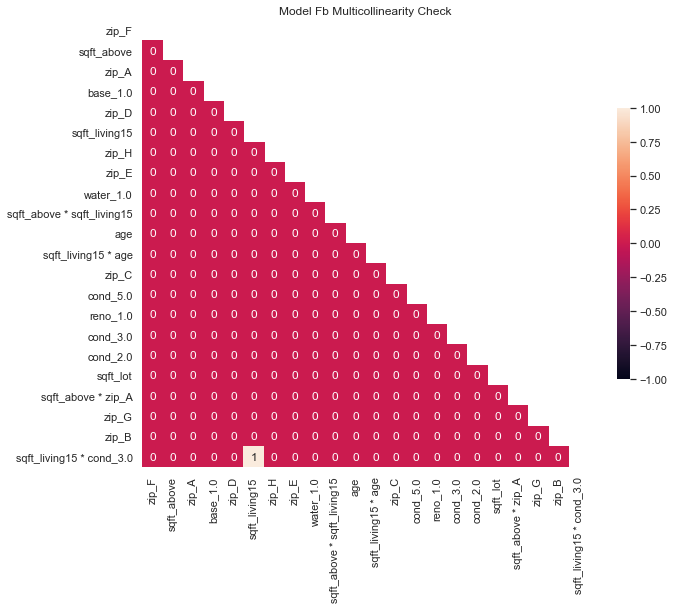

In [2654]:
#re-check for multicollinearity
mask = np.zeros_like(abs(X_interactions[result_Fb].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions[result_Fb].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model Fb Multicollinearity Check')
plt.savefig('./Data & Figures/model_Fb_multicollinearity_check')

In [2655]:
#drop collinearity
X_interactions.drop(['sqft_living15 * cond_3.0'], axis = 1, inplace = True)

In [2656]:
#re-apply stepwise function
result_Fb = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_Fb)

Add  zip_F                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 2.03162e-300
Add  water_1.0                      with p-value 9.80673e-225
Add  sqft_above * sqft_living15     with p-value 3.82919e-169
Add  age                            with p-value 1.58532e-128
Add  sqft_living15 * age            with p-value 1.57426e-97
Add  zip_I                          with p-value 6.18323e-66
Add  zip_C                          with p-value 2.06333e-44
Add  cond_5.0                       with p-value 3.92741e-39
Add  reno_1.0                       with p-value 3.53151e-24
Add  cond_3.0                       with p-value 1.69994e-22
Add  cond_2.0  

In [2657]:
#re-check for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_Fb].values, i) for i in range(X_interactions[result_Fb].shape[1])] 
list(zip(result_Fb, vif))

[('zip_F', 1.2322635511381794),
 ('sqft_above', 4.08664668009349),
 ('zip_A', 3.6443552100793437),
 ('base_1.0', 2.0772300588524293),
 ('zip_D', 1.2730765698416255),
 ('sqft_living15', 2.7404853326044325),
 ('zip_H', 1.2200876012008481),
 ('zip_E', 1.3491559575244036),
 ('water_1.0', 1.0393924604709766),
 ('sqft_above * sqft_living15', 2.270348392646229),
 ('age', 2.0545952544731056),
 ('sqft_living15 * age', 1.778388151507789),
 ('zip_C', 1.3838566731778985),
 ('cond_5.0', 1.3041749065567148),
 ('reno_1.0', 1.1501705519540428),
 ('cond_3.0', 3.9017970990337956),
 ('cond_2.0', 1.0338787252484076),
 ('sqft_lot', 1.0870212945672466),
 ('sqft_above * zip_A', 2.1732539678725016),
 ('zip_G', 1.3850267672371919),
 ('zip_B', 1.4893273377190568)]

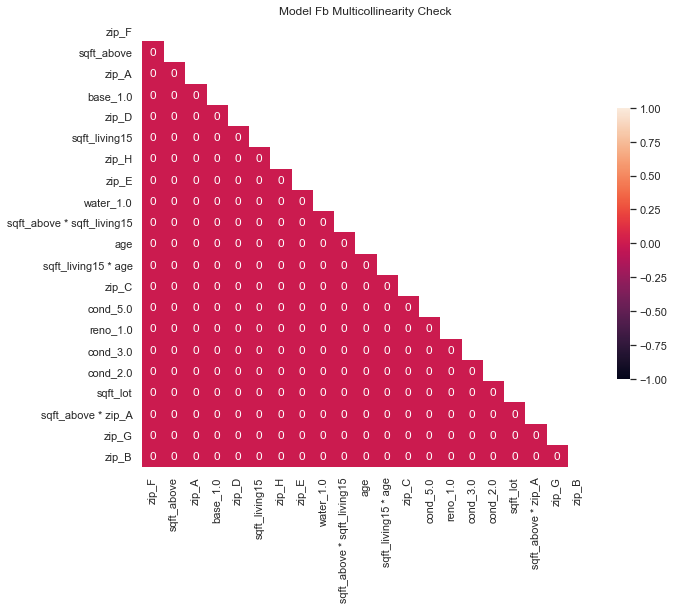

In [2658]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions[result_Fb].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions[result_Fb].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model Fb Multicollinearity Check')
plt.savefig('./Data & Figures/model_Fb_multicollinearity_check')

## Build Model Fb

In [2659]:
#create model in OLS

#interecept is not included by default and should be added manually
X_int = X_interactions[result_Fb]
X_intercept = sm.add_constant(X_int)

#estimation by OLS
model_Fb = sm.OLS(y, X_intercept).fit()

#get summary
model_Fb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     3345.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:31:08   Log-Likelihood:                -14814.
No. Observations:               21420   AIC:                         2.967e+04
Df Residuals:                   21398   BIC:                         2.985e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.2469      0.021    -11.604      0.000      -0.289      -0.205
zip_F                         -0.6933      0.023    -29.788      0.000      -0.739      -0.648
sqft_above                     0.5135      0.007     76.884      0.000       0.500       0.527
zip_A                          0.6450      0.022     29.390      0.000       0.602       0.688
base_1.0                       0.3653      0.008     47.900      0.000       0.350       0.380
zip_D                         -0.4967      0.023    -21.166      0.000      -0.543      -0.451
sqft_living15                  0.2915      0.005     53.268      0.000       0.281       0.302
zip_H                         -0.4903      0.024    -20.815      0.000      -0.537      -0.444
zip_E                         -0.3265      0.024    -13.431      0.000      -0.374      -0.279
water_1.0                      1.2751      0.041     31.259      0.000       1.195       1.355
sqft_above * sqft_living15    -0.0501      0.003    -18.521      0.000      -0.055      -0.045
age                            0.0602      0.005     12.701      0.000       0.051       0.069
sqft_living15 * age            0.0566      0.004     13.090      0.000       0.048       0.065
zip_C                          0.4776      0.022     21.351      0.000       0.434       0.521
cond_5.0                       0.1263      0.014      9.316      0.000       0.100       0.153
reno_1.0                       0.2207      0.019     11.577      0.000       0.183       0.258
cond_3.0                      -0.0903      0.008    -10.674      0.000      -0.107      -0.074
cond_2.0                      -0.4336      0.039    -11.208      0.000      -0.509      -0.358
sqft_lot                       0.0345      0.003      9.969      0.000       0.028       0.041
sqft_above * zip_A             0.0717      0.010      7.364      0.000       0.053       0.091
zip_G                          0.2582      0.023     11.323      0.000       0.213       0.303
zip_B                          0.3599      0.022     16.462      0.000       0.317       0.403
==============================================================================
Omnibus:                      620.068   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1486.237
Skew:                          -0.116   Prob(JB):                         0.00
Kurtosis:                       4.270   Cond. No.                         40.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2660]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X_interactions[result_Fb], y)

#predict yhat using our model
yhat = linreg.predict(X_interactions[result_Fb])
yhat

array([-1.38890776, -0.57406601, -0.23021778, ..., -0.67370886,
       -0.21069658, -0.67628316])

In [2661]:
#get intercept
linreg.intercept_

-0.24690968075366346

In [2662]:
#get coefficients and sort them
coefficients_Fb = dict(zip(X_interactions[result_Fb], list(linreg.coef_)))
dict(sorted(coefficients_Fb.items(), key = lambda item: item[1]))

{'zip_F': -0.693336754115425,
 'zip_D': -0.4966506991883845,
 'zip_H': -0.49034910898454415,
 'cond_2.0': -0.43355245011573246,
 'zip_E': -0.32648253708896685,
 'cond_3.0': -0.09030924108226479,
 'sqft_above * sqft_living15': -0.05010448033092488,
 'sqft_lot': 0.03453571428081498,
 'sqft_living15 * age': 0.05661388182855387,
 'age': 0.06017741512452863,
 'sqft_above * zip_A': 0.07168553828064314,
 'cond_5.0': 0.1263045775865983,
 'reno_1.0': 0.22065370153064198,
 'zip_G': 0.2581867227614699,
 'sqft_living15': 0.29146576962550946,
 'zip_B': 0.35988010735083237,
 'base_1.0': 0.36534805316202107,
 'zip_C': 0.4775949387164373,
 'sqft_above': 0.5134515861935762,
 'zip_A': 0.6449629975006929,
 'water_1.0': 1.2750505226423132}

In [2663]:
lists_Fb = sorted(coefficients_Fb.items(), key = lambda item: item[1])
a, b = zip(*lists_Fb)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model Fb Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_Fb_waterfall.png')

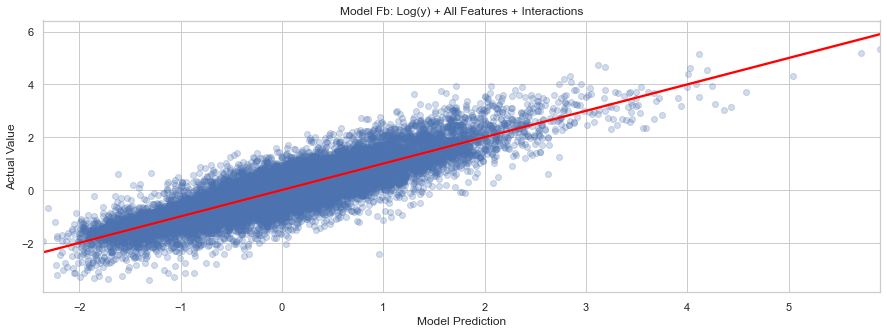

In [2664]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, scatter_kws = {'color':'b','alpha': 0.25}, line_kws = {'color': 'red'})
plt.title('Model Fb: Log(y) + All Features + Interactions')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_Fb_scatterplot')

## Rank Features for Model Fb

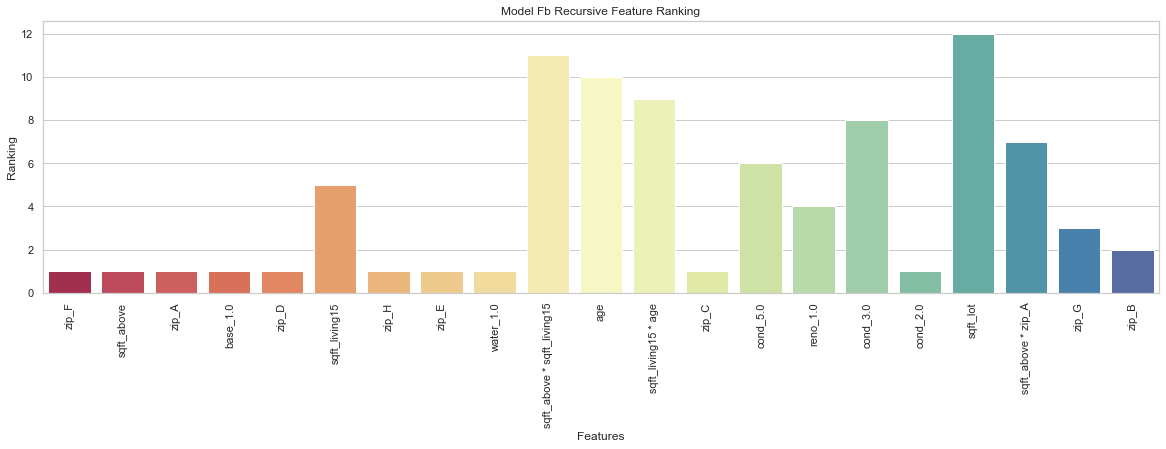

<Figure size 432x288 with 0 Axes>

In [2665]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X_interactions[result_Fb], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X_interactions[result_Fb].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model Fb Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_Fb_recursive_features_elimination')

## Test Model Fb

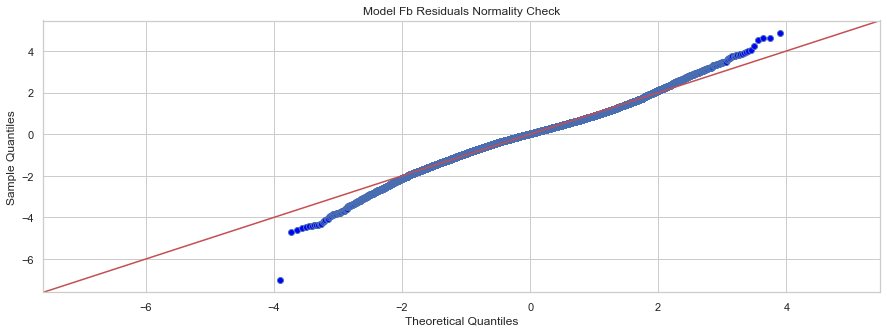

<Figure size 432x288 with 0 Axes>

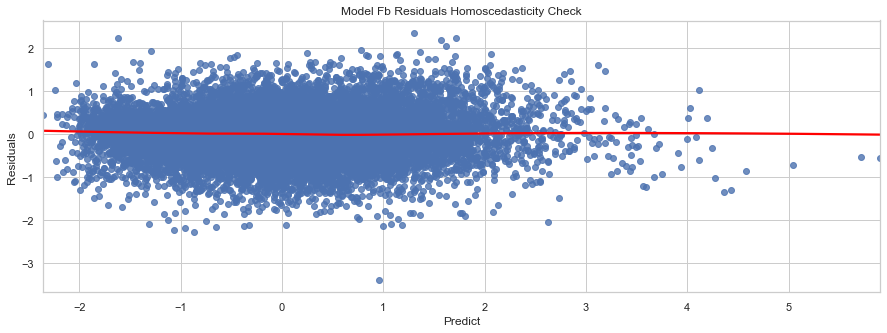

<Figure size 432x288 with 0 Axes>

In [2666]:
#recheck for normality
fig = sm.graphics.qqplot(model_Fb.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model Fb Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_Fb_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_Fb.predict(), 
            y = model_Fb.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model Fb Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_Fb_homoscedasticity_regplot')

In [2667]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_Fb.resid, model_Fb.model.exog)
list(zip(name, test))

[('F statistic', 1.0671232266915598), ('p-value', 0.000392780698102704)]

## Validate Model Fb

In [2668]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_interactions[result_Fb], y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.48528185021186926
0.47503375103363854


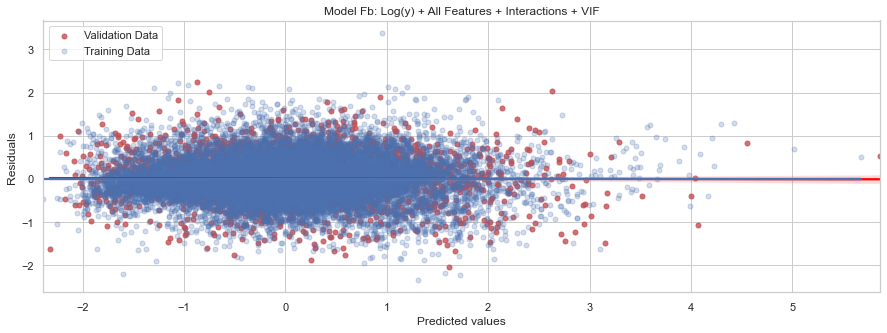

<Figure size 432x288 with 0 Axes>

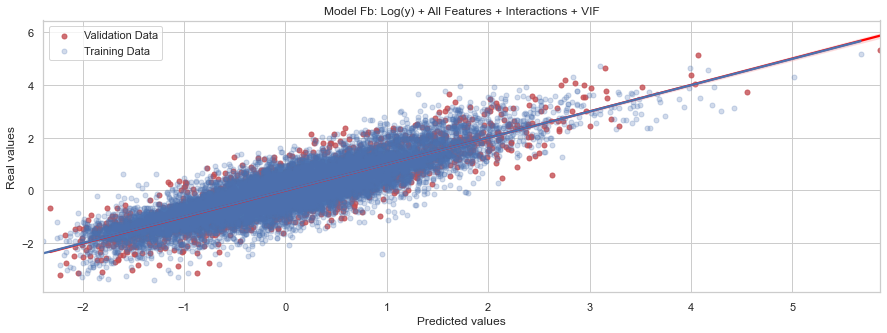

<Figure size 432x288 with 0 Axes>

In [2669]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, fit_reg = True, label = 'Training Data')


plt.title('Model Fb: Log(y) + All Features + Interactions + VIF')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_Fb_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, fit_reg = True, label = 'Training Data')

plt.title('Model Fb: Log(y) + All Features + Interactions + VIF')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_Fb_predictions_regplot')

In [2670]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 78%'

In [2671]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.27759680498874045 
Train variance: 0.3298134568390477
Test bias: 0.2810116515647249 
Test variance: 0.3222798843727821


In [2672]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_Fb.pkl','wb'))

In [2673]:
#update summary
summary_table_1.loc[7] = ['Model Fb', 'Log(y) + All features + Interactions + VIF', len(result_Fb) - 2, 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_1.head(10)

Model                                 Description   Num Features  \
0   Model A                                All features           19.0   
1   Model B         All features, outliers removed, RFE           10.0   
2   Model C        All features + Polynomial Regression           19.0   
3   Model D                       All features + Log(X)           18.0   
4  Model Ea                       Log(y) + All features           22.0   
5  Model Eb                 Log(y) + All features + VIF           19.0   
6  Model Fa        Log(y) + All features + Interactions           22.0   
7  Model Fb  Log(y) + All features + Interactions + VIF           19.0   

         r2   Accuracy  RMSE Train  RMSE Test  Bias Train  Bias Test  \
0  0.668177  66.236718    0.562527   0.628671    0.186644   0.179878   
1  0.642821  63.983660    0.535751   0.536075    0.169684   0.163239   
2  0.585625  56.964942    0.574945   0.585986   -1.227318  -1.227659   
3  0.616832  59.185618    0.599998   0.691207    0.181098   0.173259   
4  0.761546  77.329107    0.490528   0.479629   -0.124500  -0.120081   
5  0.760082  77.228842    0.492135   0.480689   -0.170410  -0.166575   
6  0.772643  78.375267    0.478963   0.468432    0.162208   0.166172   
7  0.766517  77.761485    0.485282   0.475034    0.277597   0.281012   

   Variance Train  Variance Test  Cross Validation Multicollinearity  \
0        0.210681       0.205261         -0.577799                 P   
1        0.208434       0.209862         -0.536612                 P   
2        0.154362       0.155297         -0.579514                 P   
3        0.213091       0.207496         -0.618257                 P   
4        0.300512       0.294564         -0.490940                 P   
5        0.301239       0.294849         -0.492364                 P   
6        0.307562       0.301176         -0.479175                 P   
7        0.329813       0.322280         -0.479175                 P   

  Normality Homoscedasticity  
0         F                F  
1         F                F  
2         F                F  
3         F                F  
4         P                P  
5         P                P  
6         P                P  
7         P                P

In [2674]:
#save
summary_table_1.to_csv('./Data & Figures/summary_table_1')

# BEST FIT MODEL: MODEL Fa

* Failed models: Model A, Model B, Model C, Model D failed assumption of normality.
* The version-a and version-b of Model E and Model F are the same. The only difference is in version-a we use heatmap to detect collinearity and in b-version, we go a step further and drop VIF > 10. However, while we sacrificed many cool features, r2 does not improve, even gets worse (slightly). Our decision is to stick with version-a.
* Model 1–5 (part II.B) are models with both X and y getting log-transformed. While their performance just as good as the chosen best Model F.a, because they lost interpretability due to log-transformation, they are not chosen.
* **DECISION:** Model Fa performs the best with r2 = 0.77 and accuracy of 78%.

# Model Fa Interpretation

## Q1: What are the most predictive features to predict the price of a home?

* We see that the most positively impactful features are ‘water_1.0’ and location such as 'zip_A', 'zip_C', 'zip_B', 'zip_G', 'sqft_living15'.
* Other positive features that add value to a home are: ‘sqft_above’, ‘base_1.0’, ‘bathrooms’, ‘reno_1.0’, ‘age’, ‘cond_5.0’, ‘floors’, and ‘sqft_lot’.
* Features that decrease the value of a home are: ‘bedrooms’, ‘cond_3.0’, ‘zip_E’, ‘cond_2.0’, 'zip_H', 'zip_D', 'zip_F'
* Positive interactions: 'sqft_above * zip_A', 'sqft_living15 * age'.
* Negative interactions: 'sqft_above * sqft_living15'
* RFE ranks location zipcode area ‘zip_F’, ‘zip_A’, ‘zip_D’, ‘zip_H’, 'zip_E', 'zip_C' and features such as ‘sqft_above’, ‘base_1.0’, ‘water_1.0’, ‘cond_2.0’ as top 10 most predictive features for Model Fa.